# 学习强化学习

## 1 Q-Learning Agent

Q-Learning 方法是强化学习算法家族中的一个经典算法，它有别于目前应用更加广泛的基于策略的强化学习算法，但是是入门强化学习的很好的基础。因此，整个学习路线是：首先弄懂Q-Learning的原理，完成其最基础的实现（look-up table），然后以神经网络为元件实现Q-Learning，再进入policy-based方法的学习，逐渐进入前沿强化学习方法领域。

强化学习中包含两种主流算法，基于策略的算法是直接学习如何将一个状态映射为一个动作；基于状态（动作）价值的算法则是学习每个经历状态的效益值，或者状态-动作对的效益值，然后基于该效益值筛选动作。可以看到，尽管两个方法最终都实现同一个目标——为给定状态选择合适的动作，但它们的完成方式有显著的区别。

### 1.1 基于Q-Table的方法

本小节将首先以OpenAI Gym提供的[FrozenLake](https://gym.openai.com/envs/FrozenLake-v0/)环境为研究案例。OpenAI Gym提供了一系列简单的强化学习应用场景，方便人们测试自己的算法。在Frozen Lake中，智能体将被放入一个4\*4的网格阵，每个网格对应一定的特性：

<center>
    <img style="border-radius: 0.3125em;
    box-shadow: 0 2px 4px 0 rgba(34,36,38,.12),0 2px 10px 0 rgba(34,36,38,.08);" 
    src="https://miro.medium.com/max/1050/1*MCjDzR-wfMMkS0rPqXSmKw.png" height="400" width="400">
    <br>
    <div style="color:orange; border-bottom: 1px solid #d9d9d9;
    display: inline-block;
    color: #999;
    padding: 2px;">FrozenLake环境示意图</div>
</center>

智能体在该环境的学习目标是：从起始方块（S）出发，到达目标方块（G），过程中可以经过安全方块（F），但需要避免进入危险方块（H）。智能体每一步都可以选择上下左右其中一个方向前进，但有一定概率受到“风”的影响，导致随机前进到一个方块。因此，不可能每次都完成最优的出行，但学习如何安全到达安全方块是可行的。在该环境中，每一步前进的奖赏都是0，唯有到达目标方块后获得奖赏1。

Frozen Lake可以说是一个最基础的强化学习体验案例，因为它的起始状态与终止状态都固定，且状态空间（一维16个取值）与动作空间（一维4个取值：上/下/左/右）足够小。

最简单的Q-Learning实现方式是构造一个记录状态-动作对价值的表格（Q-Table）。在该表格中，每行代表一个状态，每列代表一个动作。在Frozen Lake这个案例中，Q-Table大小是16\*4，即需要学习出16\*4个状态-动作对的价值，最后根据这些价值选择合适的动作。首先，需要将Q-Table所有值初始化为0，然后根据智能体在该环境的经历，不断更新Q-Table的各个值。采用经典的[Bellman equation](https://en.wikipedia.org/wiki/Bellman_equation) 去更新表格：以下是基于Q-Table的Q-Learning实现：

**Eq(1)**: $ Q(s,a)=r+\lambda (\mathop {\max }\limits_{a'} (Q(s',a')))$

其中，
$Q(s,a)$表示状态-动作对（s，a）的收益；r表示在状态s执行动作a的即时奖赏；$Q(s',a')$ 表示在状态s执行动作a后到达下一状态的收益；$\lambda$是折扣系数，允许我们确定当前奖赏和未来收益之间的重要性。上式说明的是，**当前状态-动作对（s，a）的期望收益等于当前获得的奖赏加上最好的长期效益**。这种更新方法使得每一次更新都重新使用了之前的更新结果，是一个迭代的过程。



In [84]:
import gym
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline


[[2.72053755e-01 1.50544608e-03 1.74821432e-03 1.57499749e-03]
 [1.19513796e-04 2.17653034e-05 2.03290833e-04 2.04320415e-01]
 [2.78101873e-04 8.89926171e-04 2.98573626e-04 2.25211476e-01]
 [8.78072687e-05 8.90557973e-04 9.08353402e-06 8.20888766e-02]
 [1.23050656e-01 1.03949714e-06 3.05869381e-04 1.03136701e-05]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00]
 [1.18321642e-02 8.03262373e-14 4.87648909e-07 2.05652472e-04]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00]
 [2.38227639e-04 1.18007016e-04 1.72953999e-06 2.55086024e-02]
 [7.58990279e-05 3.50301306e-01 6.04188263e-05 2.67943431e-04]
 [1.01994221e-01 8.12327264e-06 6.03019525e-05 5.22193016e-05]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00]
 [4.83679576e-04 2.91659825e-03 8.57743625e-01 2.28596447e-03]
 [0.00000000e+00 9.91652475e-01 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.000000

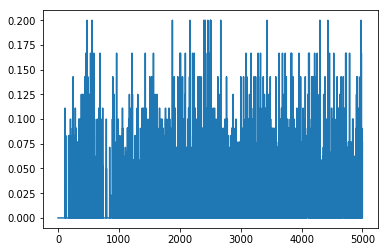

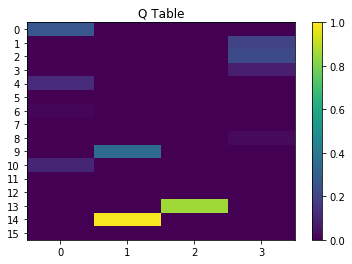

In [35]:
env = gym.make('FrozenLake-v0')
Qt = np.zeros([env.observation_space.n,env.action_space.n])

lr = 0.9
lam = 0.95
num_episodes = 5000
rAlllist=[]
rewardset=[]
for i in range(num_episodes):
    s = env.reset()
    j = 0
    max_steps_in_episode = 99
    rAll=0.
    
    while j<max_steps_in_episode:
        # action[0:Left ## 1:Down ## 2:Right ## 3:Up]
        if i<48000:
            a = np.argmax(Qt[s,:] + np.random.randn(1,env.action_space.n)*(1./(i+1)))
        else:
            a = np.argmax(Qt[s,:])
        s_next, r, d,_ = env.step(a)
        Qt[s,a] = Qt[s,a] + lr*(r+lam*np.max(Qt[s_next,:])-Qt[s,a])
        s = s_next
        rAll+=r
        if d==True:
            break
        j+=1
    rAlllist.append(rAll/j)
    if r==1:
        rewardset.append(1)
    else:
        rewardset.append(0)
print(Qt)
plt.figure(1)
plt.plot(rAlllist)
plt.figure(2)
plt.title('Q Table')       
plt.xticks(np.arange(0,env.action_space.n,1.0))
plt.yticks(np.arange(0,env.observation_space.n,1.0))
plt.imshow(Qt, interpolation='none',aspect='auto')
plt.colorbar()
plt.clim(0,1)
plt.show()

[[67. 57. 55. 39.]
 [70.  0. 36.  0.]
 [72. 73. 35.  0.]
 [ 0. 74. 76. 77.]]


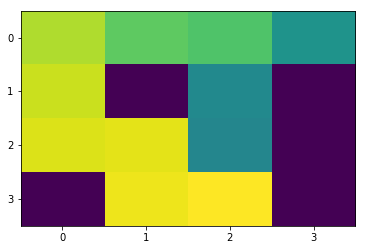

In [63]:
%matplotlib qt5
s = env.reset()
route=np.zeros([4,4])
if s_next<4:
    i=0
    j=s_next
else:
    i = int(s_next/4)
    j = s_next%4
route[i,j]=1
step=1
d=False
fig = plt.figure()
ax = fig.add_subplot(111)
fig.show()
fig.canvas.draw()
# 在线绘制agent移动路线
while d==False:
    ax.clear()
    plt.xticks(np.arange(0,4,1.0))
    plt.yticks(np.arange(0,4,1.0))
    ax.imshow(route, interpolation='none',aspect='auto')
    fig.canvas.draw()
    plt.pause(0.3)
    a = np.argmax(Qt[s,:])
    s_next, r, d,_ = env.step(a)
    step+=1
    if s_next<4:
        i=0
        j=s_next
    else:
        i = int(s_next/4)
        j = s_next%4
    route[i,j]=step
    s = s_next

print(route)

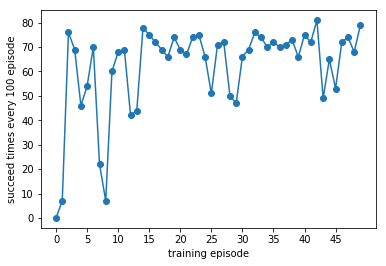

In [38]:
pass_sum=[]
i=1
a=0
while i<=len(rewardset):
    a+=rewardset[i-1]
    if i%100==0:
        pass_sum.append(a)
        a=0
    i+=1
plt.xticks(np.arange(0,len(pass_sum), 5.0))
plt.yticks(np.arange(0,max(pass_sum)+1, 10.0))
plt.plot( pass_sum,'-o')
plt.xlabel('training episode/100')
plt.ylabel('succeed times every 100 episode')
plt.show()

### 1.2 基于Q-Network的方法

很容易可以想到：当状态空间和动作空间非常大时，Q-Table往往要求庞大的存储空间，且不够灵活，为了降低存储消耗，我们可以通过构造一个函数去估计Q-Table，神经网络是一个常见且有效的选择，利用神经网络去充当估计器，我们可以通过构造（特征）向量表示任意状态，生成神经网络的输入，然后让网络学习状态对应的效益值。

在本小节的案例中，我们可以通过one-hot向量去描述(输入)状态：: $s\in R^{1x16}$,而对应的输出则是该状态下，执行每个可选动作的效益值：$Q\in R^{1x4}$。在神经网络中，我们通过梯度下降优化损失函数的方式进行“Q-Table”的更新学习，对应的损失函数为：

**Eq(2)**: $Loss=\sum (Q_{target}-Q_{estimate})^2$

$Q_{target}=r+\lambda (\mathop {\max }\limits_{a'} (Q_{estimate}(s',a'))))$

实际上，在处理FrozenLake问题时，神经网络并不比Q-Table方法来的多高效。同时需要指出，尽管利用神经网络拟合Q值为描述Q值带来了更大的灵活性，但该方法在进行Q-Learning时稳定性不佳，收敛花费时间较长。当下有大量基于神经网络进行Q-Learning的扩展研究，目的就是为了寻求一个更好更稳定的Q值估计结果，在这些研究中，尤为著名的是[Atari-playing Deep Q-Networks](https://web.stanford.edu/class/psych209/Readings/MnihEtAlHassibis15NatureControlDeepRL.pdf)中提出的**Experience Replay**和**冻结目标网络** ：

**Experience Replay**

在智能体与环境交互时，存储每次的经历$<s,a,r,s'>$，存储点记为replay memory。在训练Q神经网络时，在replay memory中随机采样出经历，而非使用最近的经历。这样的做法可以打破每批训练样本的相似性，以免网络过早陷入局部最优。同时，Experience Replay的使用让学习过程与一般的监督学习更为相似，这也一定程度简化了算法的调试流程，特别地，我们甚至可以人工收集经历，然后再让智能体学习。

**冻结目标网络**

在公式2中，损失函数中的目标值$Q_{target}=r+\lambda (\mathop {\max }\limits_{a'} (Q_{estimate}(s',a'))))$需要估计，冻结目标网络实质上是通过构造一个与原训练神经网络构造完全一样的“目标网络”去完成这个估计。具体来说，每当原训练神经网络的参数更新了一段时间，我们就将该套参数加载到“目标网络”，在更新原训练神经网络时，用“目标网络”去估计目标值。这一做法相比于传统的在线Q-Learnig会使训练更加稳定，因为在以往的在线Q-Learning中，网络更新会立即影响$Q_{target}$，很可能会导致策略的振荡甚至发散，冻结目标网络使得目标值的估计可以稳定一段时间，使得策略学习更不易发散。

**Q-Network Approach in Tensorflow**(训练结果很不稳定且智能体策略在loss function优化时没有改进)

episode: 130 loss: 0.0638338
episode: 135 loss: 0.068826
episode: 140 loss: 0.0953163
episode: 145 loss: 0.103538
episode: 150 loss: 0.14007
episode: 155 loss: 0.15388
episode: 160 loss: 0.0674581
episode: 165 loss: 0.0612548
episode: 170 loss: 0.0922637
episode: 175 loss: 0.0691658
episode: 180 loss: 0.099842
episode: 185 loss: 0.106275
episode: 190 loss: 0.0614138
episode: 195 loss: 0.0571792
episode: 200 loss: 0.0538346
episode: 205 loss: 0.099797
episode: 210 loss: 0.0616007
episode: 215 loss: 0.130676
episode: 220 loss: 0.0756271
episode: 225 loss: 0.0655743
episode: 230 loss: 0.0415326
episode: 235 loss: 0.0785157
episode: 240 loss: 0.0970408
episode: 245 loss: 0.149845
episode: 250 loss: 0.0477099
episode: 255 loss: 0.0612625
episode: 260 loss: 0.0982781
episode: 265 loss: 0.0596654
episode: 270 loss: 0.0798727
episode: 275 loss: 0.0527652
episode: 280 loss: 0.0856345
episode: 285 loss: 0.0381688
episode: 290 loss: 0.0931403
episode: 295 loss: 0.0950404
episode: 300 loss: 0.0883

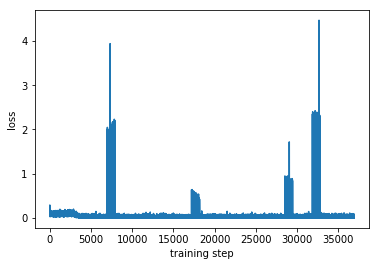

In [56]:
import tensorflow as tf
import gym
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
env = gym.make('FrozenLake-v0')
def weight_variable(shape,train=True):
    initial = tf.truncated_normal(shape, stddev=0.1)
    return tf.Variable(initial,trainable=train)
def bias_variable(shape,train=True):
    initial = tf.truncated_normal(shape, stddev=0.1)
    return tf.Variable(initial,trainable=train)

state_dim_ = env.observation_space.n
action_num_ = env.action_space.n

class DQN():
    def __init__(self, sess, state_dim, action_dim=1, lamda=0.95, updateStep=3, output_num=4):
        self.state_dim = state_dim
        self.action_dim = action_dim
        self.state = tf.placeholder(tf.float32,[None,self.state_dim],name='state')
        self.next_state = tf.placeholder(tf.float32,[None,self.state_dim],name='next_state')
        self.lamda = lamda
        self.updateStep = updateStep
        self.action_output_num = output_num
        self.sess = sess
        self.reward_holder = tf.placeholder(tf.float32,[None], name='reward')
        self.action_index = tf.placeholder(shape=None,dtype=tf.int32)
        
    def buildQNetwork(self,):
        
        with tf.variable_scope('update-Qnetwork'):
            w1 = weight_variable([self.state_dim,24])
            b1 = bias_variable([24])
            w2 = weight_variable([24,self.action_output_num])
            b2 = bias_variable([self.action_output_num])
            
        with tf.variable_scope('target-Qnetwork'):
            w1_ = weight_variable([self.state_dim,24],train=False)
            b1_ = bias_variable([24],train=False)
            w2_ = weight_variable([24,self.action_output_num],train=False)
            b2_ = bias_variable([self.action_output_num],train=False)
                                
        self.e_params = tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES, scope='update-Qnetwork')
        self.t_params = tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES, scope='target-Qnetwork')
                                
        self.h1 = tf.nn.elu(tf.matmul(self.state, w1)+b1)
        self.Qs = (tf.matmul(self.h1,w2)+b2)
        
        self.h1_next = tf.nn.elu(tf.matmul(self.next_state, w1_)+b1_)
        self.nextQs = (tf.matmul(self.h1_next,w2_)+b2_)
        
        increasing = tf.range(start=0, limit=tf.shape(self.action_index)[0], delta=1)
        mask = tf.stack([increasing, self.action_index], axis=1)
        self.Q = tf.gather_nd(self.Qs, mask)
        
        self.nextQ = tf.reduce_max(self.nextQs,axis=1)
        self.targetQ = self.reward_holder+self.lamda*self.nextQ
        self.loss = tf.reduce_mean(tf.squared_difference(self.targetQ, self.Q))
        
        self.a = tf.argmax(self.Qs,1)
        
        self.trainOp = tf.train.AdamOptimizer(learning_rate=0.005).minimize(self.loss)
    
    def learn(self,step,memory):
        _, loss = self.sess.run([self.trainOp,self.loss], feed_dict={self.state : memory[:,0:self.state_dim], 
                                                                     self.next_state: memory[:,self.state_dim:self.state_dim*2],
                                                                     self.action_index:memory[:,-2],
                                                                     self.reward_holder:memory[:,-1]})
        
        if step%self.updateStep==0:
            self.sess.run([tf.assign(tar,  eva) for tar, eva in zip(self.t_params, self.e_params)])
        return loss
    
    def choose_action(self,state,epsilon=0.9):
        if np.random.uniform() < epsilon:
            return [np.random.randint(0, 4)]
        else:
            return self.sess.run(self.a, feed_dict={self.state:state})
    def predict_nextQ(self,next_state):
        return np.max(self.sess.run(self.nextQs, feed_dict={self.next_state:next_state}))
    
class replay_memory():
    def __init__(self, memory_capacity, state_dim, action_dim=1):
        self.memory_capacity = memory_capacity
        self.memory = np.zeros((self.memory_capacity, 2*state_dim+action_dim+1))  
        self.pointer = 0
        
    def store_experience(self, state, next_sate,action,reward):
        index = self.pointer%self.memory_capacity
        experience  = np.hstack((state,next_sate,action,reward))
        self.memory[index,:]=experience
        self.pointer+=1
        
    def replay(self,batch_size):
        
        memory_batch = []
        pos=0
        for i in range(batch_size):
            index = np.random.randint(0,self.memory_capacity)
            memory_batch.append(self.memory[index,:])

        return memory_batch        
    
    
tf.reset_default_graph()
sess_ = tf.Session()
model = DQN(state_dim=state_dim_, lamda=0.95,updateStep=200, sess=sess_)
model.buildQNetwork()
init_op = tf.group(tf.global_variables_initializer(), tf.local_variables_initializer())
sess_.run(init_op)

M = replay_memory(memory_capacity=1000, state_dim=state_dim_, action_dim=1)
batch_size_ = 32
num_episodes = 1500

records = 0
loss_set=[]
e=1.
rewardset=[]

for i in range(num_episodes):
    s = env.reset()
    j = 0
    max_steps_in_episode = 99
    if i>500:
        e=0.01
    reward=0
    while True:
        state_vector = np.zeros([1,state_dim_])
        state_vector[0,s]=1
        a = model.choose_action(state=state_vector,epsilon=e)
        s_next, r, d,_ = env.step(a[0])
        if r==0 and d==True:
             M.store_experience(state=state_vector[0], next_sate=nextSate_vector[0],action=a,reward=[-1])
        else:
             M.store_experience(state=state_vector[0], next_sate=nextSate_vector[0],action=a,reward=[r])

        nextSate_vector = np.zeros([1,state_dim_])    
        nextSate_vector[0,s_next]=1

       
        records+=1
        j+=1
        
        s = s_next
        
        if records>M.memory_capacity:
            memory_batch = M.replay(batch_size=batch_size_)
            loss_ = model.learn(records,memory=np.array(memory_batch) )
            loss_set.append(loss_)
        if d==True:
            break
            
    if records>M.memory_capacity and i%5==0:
        print('episode: %d loss: %g'%(i, loss_))
        
    if r==1:
        rewardset.append(1) 
    else:
        rewardset.append(0)
        
plt.plot(loss_set)
plt.xlabel('training step')
plt.ylabel('loss')
plt.show()

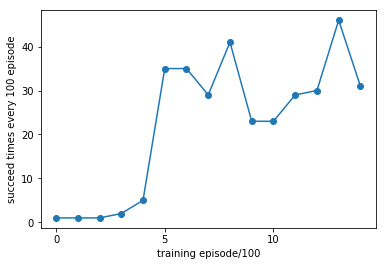

In [57]:
pass_sum=[]
i=1
a=0
while i<=len(rewardset):
    a+=rewardset[i-1]
    if i%100==0:
        pass_sum.append(a)
        a=0
    i+=1
plt.xticks(np.arange(0,len(pass_sum), 5.0))
plt.yticks(np.arange(0,max(pass_sum)+1, 10.0))
plt.plot( pass_sum,'-o')
plt.xlabel('training episode/100')
plt.ylabel('succeed times every 100 episode')
plt.show()

In [133]:
Qtable=np.zeros((16, 4))
for i in range(state_dim_):
    state_vector=np.zeros([1,state_dim_])
    state_vector[0,i] = 1
    Q_ = sess_.run(model.Qs, feed_dict={model.state:state_vector})
    Qtable[i,:]=np.array(Q_[0])

print(Qtable)

[[-0.60792506 -0.69701785 -0.90225601 -0.71758783]
 [-0.46534681 -0.52343231 -0.65084064 -0.1598776 ]
 [ 0.41554064  0.38331717  0.30515468  0.38228363]
 [-0.24893263 -0.04630597 -0.49572989 -0.01304639]
 [-0.03576422 -0.3105897  -0.7536543  -0.40350515]
 [-0.97154945 -1.00897026 -1.21694016 -1.07751966]
 [-4.76211977 -5.17685223 -5.00145721 -5.76091003]
 [-1.07341886 -1.10727549 -1.36860645 -1.16024959]
 [-0.61588264 -0.18740179 -0.7396189  -0.12182092]
 [-0.68083769 -0.01735926 -0.74827331 -0.42034298]
 [-0.03293187 -0.57222044 -1.01235747 -0.50757867]
 [-0.80975497 -0.94368947 -1.11204052 -0.84587127]
 [-0.9436143  -1.0189625  -1.19205689 -1.03358006]
 [-0.43878788  0.18124294  0.17134959  0.10830718]
 [ 6.30049276  6.1351738   6.95144892  6.68672514]
 [-0.90302402 -0.90628636 -1.1184423  -0.82351041]]


In [134]:
# %matplotlib qt5
s = env.reset()
route=np.zeros([4,4])
if s<4:
    i=0
    j=s
else:
    i = int(s_next/4)
    j = s%4
    
route[i,j]=1
step=1
d=False
print(route)
# fig = plt.figure()
# ax = fig.add_subplot(111)
# fig.show()
# fig.canvas.draw()
# 在线绘制agent移动路线
while d==False:
#     ax.clear()
#     plt.xticks(np.arange(0,4,1.0))
#     plt.yticks(np.arange(0,4,1.0))
#     ax.imshow(route, interpolation='none',aspect='auto')
#     fig.canvas.draw()
#     plt.pause(0.3)
    
    state_vector=np.zeros([1,state_dim_])
    state_vector[0,s] = 1
    a = model.choose_action(state=state_vector,epsilon=-1)
    Qs = sess_.run(model.Qs, feed_dict={model.state:state_vector})
    print(Qs)
    s_next, r, d,_ = env.step(a[0])
    step+=1
    if s_next<4:
        i=0
        j=s_next
    else:
        i = int(s_next/4)
        j = s_next%4
    route[i,j]=step
    print(route)
    s = s_next



[[1. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]]
[[-0.60792506 -0.69701785 -0.902256   -0.7175878 ]]
[[1. 0. 0. 0.]
 [2. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]]
[[-0.03576422 -0.3105897  -0.7536543  -0.40350515]]
[[1. 0. 0. 0.]
 [2. 0. 0. 0.]
 [3. 0. 0. 0.]
 [0. 0. 0. 0.]]
[[-0.61588264 -0.18740179 -0.7396189  -0.12182092]]
[[1. 0. 0. 0.]
 [4. 0. 0. 0.]
 [3. 0. 0. 0.]
 [0. 0. 0. 0.]]
[[-0.03576422 -0.3105897  -0.7536543  -0.40350515]]
[[5. 0. 0. 0.]
 [4. 0. 0. 0.]
 [3. 0. 0. 0.]
 [0. 0. 0. 0.]]
[[-0.60792506 -0.69701785 -0.902256   -0.7175878 ]]
[[5. 0. 0. 0.]
 [6. 0. 0. 0.]
 [3. 0. 0. 0.]
 [0. 0. 0. 0.]]
[[-0.03576422 -0.3105897  -0.7536543  -0.40350515]]
[[5. 0. 0. 0.]
 [7. 0. 0. 0.]
 [3. 0. 0. 0.]
 [0. 0. 0. 0.]]
[[-0.03576422 -0.3105897  -0.7536543  -0.40350515]]
[[5. 0. 0. 0.]
 [8. 0. 0. 0.]
 [3. 0. 0. 0.]
 [0. 0. 0. 0.]]
[[-0.03576422 -0.3105897  -0.7536543  -0.40350515]]
[[5. 0. 0. 0.]
 [8. 0. 0. 0.]
 [9. 0. 0. 0.]
 [0. 0. 0. 0.]]
[[-0.61588264 -0.18740179 -0.739618

### 参考资料

[1][Simple Reinforcement Learning with Tensorflow Part 0: Q-Learning with Tables and Neural Networks](https://medium.com/emergent-future/simple-reinforcement-learning-with-tensorflow-part-0-q-learning-with-tables-and-neural-networks-d195264329d0)

[2][DEMYSTIFYING DEEP REINFORCEMENT LEARNING](https://neuro.cs.ut.ee/demystifying-deep-reinforcement-learning/)

[3][Convergence of Q-Learning: a simple proof](http://users.isr.ist.utl.pt/~mtjspaan/readingGroup/ProofQlearning.pdf)

## 2 Policy-based Agent 

## 2.1 Two-armed Bandit

强化学习使得我们不仅得以教一个智能体如何工作，并允许智能体通过与环境的交互自行学习如何工作。深度神经网络借助目的导向学习的智能体，可以学习到复杂的环境表达信息，结合学习到的表达，计算机取得了一些令人惊叹的成就，包括[在Atari games上击败人类](https://deepmind.com/research/dqn/)以及[击败围棋冠军](https://deepmind.com/research/alphago/)。

学习如何构造这些智能体要求我们从监督学习的工作思路中转变过来。那种找个算法去匹配某些确定刺激和其响应的能力已经不再靠谱了，相反，强化学习算法必须能够使智能体基于“环境状态”，“即时奖赏”以及“动作”这几个元素，自主去获取并学习到合适的输入输出关系。此时，现在无论在何种场景，我们不再能告诉智能体理应执行的所谓的正确的行为，因此，问题相对更加复杂。

本小节将以新的一个小问题来探索强化学习——n-armed bandit，也就是n个摇杆的老虎机，每个摇杆都对应固定的选择几率。这个游戏的目标是摸索出这个老虎机最优的摇杆选择几率组合，即一种投币策略，来最大化每次执行该策略获取的奖赏。现在我们先进一步简化这个问题，研究对象选为一个两个摇杆的老虎机。事实上，这个简化后的问题也太简单了，就姑且将它视为更多是一个解决实际强化学习问题的探路者。

需要强调的是，被视为强化学习问题的任务会具备以下典型的特点：

- 不同的动作决策对应不同的即时奖赏。打个比方，当在一个迷宫寻宝时，在某个位置向右走得到宝藏，向左走遇见陷阱。

- 考虑奖赏的前瞻性。即考虑将来可能发生的奖赏，在我们到达向右走就可以得到宝藏的位置前，我们应首先认识到走到该位置是诱人的。

- 动作决策的奖赏是基于所处的状态的。在某个位置执行的动作，获取了好的奖赏，在另一个位置执行相同的动作却不一定同样获得好的回报。

此次的案例是一个非常简单的开始，它不考虑所处的状态（每次都一样），也不考虑长远收益（前后两个动作相互独立），即忽略了后两个要素。我们需要关注的仅仅是去认识每个动作对应的可能的奖赏，并学习如何去最大化获得的奖赏，如何实现这个目标以强化学习的术语来表达就是策略（policy）——现在我们关注policy-based agent，相比于Q-Learning **“环境$\rightarrow$Q value$\rightarrow$动作”**的工作模式，现在的思路是**“环境$\rightarrow$动作”**，也根据就是直接学习环境到动作的映射。这里用到的优化算法是[policy gradient](http://papers.nips.cc/paper/1713-policy-gradient-methods-for-reinforcement-learning-with-function-approximation.pdf)：构造接受环境状态输入，输出动作的神经网络作为决策单元，通过智能体与环境的交互推导出优化神经网络权重的梯度，进行权重的更新。

### Policy gradient

本小节主要参考Sutton等人的著作，将从比较数学的角度捋一遍policy gradient：

将根据状态选择动作的策略参数化：

**Eq(3)**:$\pi(a|s,\theta)=Pr\{A_t=a|S_t=s,\theta_{t}=\theta\}$

基于参数化策略，可以定义某策略下，从任意一个状态$s$出发执行策略的期望效益为：

**Eq(4)**：$J(\theta)\dot{=}v_{\pi}(s)=\sum\limits_{s\in S}\mathop {\sum }\limits_{a}\pi(a|s,\theta)Q_{\pi}(s,a)$

其中，$\mu{(s)}= \sum\limits_{k=0}^{\infty}\gamma^{k} Pr(s \rightarrow x,k,\pi)$考虑了从状态$s$出发到任意一个状态$x$的概率及经历的期望步数$k$，表达从状态$s$出发到任意一个状态$x$的的期望折扣。

很自然可以想到用梯度上升的方式优化上式，需要指出的是，策略参数的更新梯度通过执行的动作和对应的奖赏可以比较直截了当地获得，但执行的策略导致的状态转移是基于所处环境的一个未知表达，因此无法计算这方面作用的梯度，幸运的是，Sutton等人已经证明策略的更新梯度计算不需要考虑状态转移函数的梯度，得出简洁的策略梯度定理：

> **Eq(5)**:$\bigtriangledown J(\theta) \propto \mathop {\sum }\limits_{s}\mu{(s)}\mathop {\sum }\limits_{a}\bigtriangledown \pi(a|s,\theta)Q_{\pi}(s,a)$
,$\mu{(s)}= \sum\limits_{k=0}^{\infty}\gamma^{k} Pr(s \rightarrow x,k,\pi)$


#### Reinforce


把**Eq(5)**视为基于策略$\pi$的期望：

$ \mathop {\sum }\limits_{s}\mu{(s)}\mathop {\sum }\limits_{a}\bigtriangledown \pi(a|s,\theta)Q_{\pi}(s,a)=E_{\pi}[\gamma^{k}\mathop {\sum }\limits_{a}\bigtriangledown \pi(a|s,\theta)Q_{\pi}(s,a)]$

简单的变形：

$E_{\pi}[\gamma^{k}\mathop {\sum }\limits_{a}\bigtriangledown \pi(a|s,\theta)Q_{\pi}(s,a)]=E_{\pi}[\gamma^{k}\mathop {\sum }\limits_{a}\bigtriangledown \pi(a|s,\theta)Q_{\pi}(s,a)\frac{\pi(a|s,\theta)}{\pi(a|s,\theta)}]=E_{\pi}[\gamma^{k}\mathop {\sum }\limits_{a}\bigtriangledown log \pi(a|s,\theta)Q_{\pi}(s,a) {\pi(a|s,\theta)} ]$

由于动作$a$来源于策略$\pi$,既有$A_{t}~\pi$，将动作与状态都视为随机变量，此时上述期望进一步化解：

**Eq(6)**：$\bigtriangledown J(\theta)=E_{\pi}[\gamma^{k} \bigtriangledown log \pi(A_t|S_t,\theta)Q_{\pi}(S_t,A_t)]$

以上即基于策略梯度定理的Reinforce算法，算是策略梯度一类方法的鼻祖，它基于MC的方法进行采样计算梯度，可以看到，为了得到$Q(S_t,A_t)$，每次的MC都需要经历一个完整的episode，故Reinforce只能用于finite-episode的场景，且效率较低，训练方差较大。

#### Reinforce with Baseline

在**Eq(6)**中，为了减少梯度的方差，使得训练更加平稳，让效益值减去baseline使得每次效益值尽可能固定：

$E_{\pi}[\gamma^{k}\mathop {\sum }\limits_{a}\bigtriangledown \pi(a|s,\theta)(Q_{\pi}(s,a)-b(s))]$

由于$E_{\pi}[\gamma^{k} \bigtriangledown \pi(A_t|S_t,\theta)b(S_t)]=\mathop {\sum }\limits_{a}\bigtriangledown \pi(a|s,\theta)b(s)=b(s)\bigtriangledown 1=0$，因此这个trick保证了训练稳定性的同时，并不影响梯度的计算。这是Reinforce的一种改进。

#### Actor-Critic

尽管Reinforce with baseline算法实际上是在学习策略和估计状态价值，但它估计状态价值仅充当baseline，因此并不能称为一个critic。换句话说，Actor-Critic和Reinforce with baseline最大的区别就是：critic实现状态价值估计不仅仅为了充当baseline，更重要是实现bootstrapping，即依据接下来的状态估计更新当前的状态估计，更适合在线运行。

### A naive trial : Multi-armed bandit with policy gradient in TensorFlow

In [27]:
# 最简单版本的策略梯度案例
import tensorflow as tf
import numpy as np

bandits = [0.2,0,-0.2,-5]


def pullBandit(bandit):
    result = np.random.randn(1)
    if result>bandit:
        return 1 # positive reward
    else: return -1

def weight_variable(shape):
    initial = tf.truncated_normal(shape, stddev=0.5)
    return tf.Variable(initial)
    
class agent():
    def __init__(self,):
        self.action = tf.placeholder(tf.int32,[1], name='action')
        self.reward = tf.placeholder(tf.float32,[1], name='reward')
    def buildPolicyNetwork(self, num_bandits):
        self.weight = tf.Variable(tf.ones([num_bandits]))
        self.responsible_weight = tf.slice(self.weight, self.action, [1])
        self.loss = -tf.reduce_mean(self.reward*tf.log(self.responsible_weight))
        self.trainOp = tf.train.AdamOptimizer(learning_rate=0.04).minimize(self.loss)
    def choos_action(self,):
        return tf.argmax(self.weight,0)
    
num_episodes = 1000

tf.reset_default_graph()
sess_ = tf.Session()
model = agent( )
model.buildPolicyNetwork(num_bandits=len(bandits))
init_op = tf.group(tf.global_variables_initializer(), tf.local_variables_initializer())
sess_.run(init_op)

exploration_prob = 0.1
for i in range(num_episodes):
    if np.random.randn(1)<exploration_prob:
        action = np.random.randint(len(bandits))
    else:
        action = sess_.run(model.choos_action())
    reward = [pullBandit(bandits[action])]
    sess_.run(model.trainOp, feed_dict={model.reward:reward, model.action:[action]})
    if i%100==0:
        print(sess_.run(model.weight))

[1.   1.04 1.   1.  ]
[0.59079117 1.2490311  1.786226   3.3703156 ]
[0.89357394 1.3589152  2.2559717  5.3832917 ]
[0.1792259 1.2719303 2.3610716 6.8748937]
[-0.59942985  0.9029873   2.2593598   8.167424  ]
[-0.21109875  0.71019924  2.6749518   9.356331  ]
[-0.6982591  0.6935626  3.129112  10.754131 ]
[-0.73552233  0.7496382   3.050733   12.075997  ]
[-0.59368587  0.9900622   3.1868832  13.366019  ]
[-0.9071643  0.7517966  3.7111242 14.533899 ]


#### A maturer trial : Cart-Pole task

上述案例展示了不考虑状态影响和长期奖赏时，如何利用策略梯度训练智能体，使其选择奖赏更高的动作。接下来将构造一个更加完满的强化学习智能体，让它既可以感知环境状态，又不仅仅局限于即时奖赏。

在强化学习中，智能体的外界环境可被看作是一个马尔可夫过程（Markov Decision Process）。这种环境提供奖赏以及状态转移作为智能体决策的反馈，值得指出的是，其奖赏基于状态本身以及智能体在该状态下所执行的动作。整个环境的反馈过程是具有时变性的，并有可能存在一定的延时。

更加正式的定义马尔可夫决策过程：

一个马尔科夫过程包含状态集合$S$，这些状态$s$可能被智能体在任意时间经历；包含可行动作集合$A$，其中每个$a$是智能体任意时间可能决策的动作。给的状态-动作对$(s,a)$，可以定义下一状态$s'$的转移概率$T(s,a,s')$，以及即时奖赏$R(s,a)$。基于以上定义，在任意MDP中，智能体接受输入状态$s$，执行动作$a$，到达新的状态$s'$并获取奖赏$r$。

选择OpenAI gym的Cart-Pole案例进行策略梯度的更完善的实验。在该实验中，我们将训练智能体如何保持一跟竖杆的平衡，使之不倒下，该任务包含的强化学习要是如下：

- 输入输出：智能体需要知道竖杆的当前位置，然后推算它平衡时的角度。为了实现这个目标，我们建立的神经网络需要接受输入状态并输出一个动作的概率。

- 延迟奖赏：我们尽可能长时间的保持竖杆平衡，这要求智能体不仅仅考虑当下的奖赏，还应有长远的考虑。为了实现这一点，每一个状态-动作对下的效益值应该是一个引入延迟系数的长期奖赏。

以下将利用**Actor-Critic**解决Cart-Pole(学习率对训练效果的影响比较显著):

In [92]:
import tensorflow as tf
import tensorflow.contrib.slim as slim
import numpy as np
import gym
import matplotlib.pyplot as plt
%matplotlib inline

np.random.seed(2)
tf.set_random_seed(2)  # reproducible
env = gym.make('CartPole-v0')
env.seed(1)  # reproducible
state_dim = env.observation_space.shape[0]
action_dim = env.action_space.n

In [53]:
class replay_memory():
    def __init__(self, memory_capacity, state_dim, action_dim=1):
        self.memory_capacity = memory_capacity
        self.memory = np.zeros((self.memory_capacity, 2*state_dim+action_dim+1+1+1+1))   # state, action ,reward ,next state, action index,q，target q
        self.pointer = 0
        
    def store_experience(self, state, action, reward, next_sate,action_index,v_value,target_v):
        index = self.pointer%self.memory_capacity
        experience  = np.hstack((state, action, reward, next_sate,action_index,v_value,target_v))
        self.memory[index,:]=experience
        self.pointer+=1
        
    def replay(self,batch_size):
        memory_batch = []
        for i in range(batch_size):
            index = np.random.randint(0,self.memory_capacity)
            memory_batch.append(self.memory[index,:])
        return np.array(memory_batch)

In [58]:
def weight_variable(shape,train=True):
    initial = tf.truncated_normal(shape, stddev=0.1)
    return tf.Variable(initial,trainable=train)
def bias_variable(shape,train=True):
    initial = tf.constant(value=0.1,shape=shape)
    return tf.Variable(initial,trainable=train)

class agent():
    def __init__(self, action_dim=2, state_dim=4 ):
        self.state_dim = state_dim
        self.action_dim = action_dim
        self.action = tf.placeholder(tf.float32,[None, action_dim], name='action')
        self.state = tf.placeholder(tf.float32,[None,state_dim], name='state')
        self.next_state = tf.placeholder(tf.float32,[None,state_dim], name='next_state')
        self.reward = tf.placeholder(tf.float32,[None,1], name='reward')
        self.action_index = tf.placeholder(tf.int32, [None], name='a')
        self.V_holder = tf.placeholder(tf.float32, [None,1], name='Qvalue')
        self.targetV =  tf.placeholder(tf.float32, [None,1], name='Target_Qvalue')
        
    def buildCriticNetwork(self,):
        with tf.variable_scope('update-Critic_network'):
            w1 = weight_variable([self.state_dim, 20])
            b1 = bias_variable([20])
            w2 = weight_variable([20, 1])
            b2 = bias_variable([1])
        with tf.variable_scope('target-Critic_network'):
            w1_ = weight_variable([self.state_dim, 20],train=False)
            b1_ = bias_variable([20],train=False)
            w2_ = weight_variable([20, 1],train=False)
            b2_ = bias_variable([1],train=False) 
            
        self.v_e_params = tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES, scope='update-Critic_network')
        self.v_t_params = tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES, scope='target-Critic_network')
 
        h1 = tf.nn.elu(tf.matmul(self.state, w1)+b1)
        self.V =  tf.identity(tf.matmul(h1, w2)+b2)

        h1_next = tf.nn.elu(tf.matmul(self.next_state, w1_)+b1_)
        self.nextV = tf.identity(tf.matmul(h1_next, w2_)+b2_)
        
        self.v_loss = tf.reduce_mean(tf.squared_difference(self.targetV, self.V))
        self.v_trainOp = tf.train.AdamOptimizer(learning_rate=0.1).minimize(self.v_loss)
        
        self.Critic_network_update=[tf.assign(tar, eva) for tar, eva in zip(self.v_t_params, self.v_e_params)]
        
    def buildActorNetwork(self, ):
        with tf.variable_scope('update-Actor_network'):
            w1 = weight_variable([self.state_dim, 20])
            b1 = bias_variable([20])
            w2 =  weight_variable([20, self.action_dim])
            b2 = bias_variable([self.action_dim])
            
        with tf.variable_scope('target-Actor_network'):
            w1_ = weight_variable([self.state_dim, 20],train=False)
            b1_ = bias_variable([20],train=False)
            w2_ =  weight_variable([20, self.action_dim],train=False)
            b2_ = bias_variable([self.action_dim],train=False)
            
        self.p_e_params = tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES, scope='update-Actor_network')
        self.p_t_params = tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES, scope='target-Actor_network')
        
        self.h = tf.nn.elu(tf.matmul(self.state, w1)+b1)
        self.action_output = tf.nn.softmax(tf.matmul(self.h, w2)+b2)
        
        self.h_ = tf.nn.elu(tf.matmul(self.next_state, w1_)+b1_)
        self.next_action_output = tf.nn.softmax(tf.matmul(self.h_, w2_)+b2_)
     
        
        # Gather  responsible output corresponding to the action for training
        increasing = tf.range(start=0, limit=tf.shape(self.action_output)[0], delta=1)
        mask = tf.stack([increasing, self.action_index], axis=1)
        self.result = tf.gather_nd(self.action_output, mask)
        
        td = self.targetV-self.V_holder
        self.p_loss = -tf.reduce_mean(tf.log(self.result)*(td))
        self.p_trainOp = tf.train.AdamOptimizer(learning_rate=0.001).minimize(self.p_loss)
    
        self.Actor_network_update=[tf.assign(tar, eva) for tar, eva in zip(self.p_t_params, self.p_e_params)]
        
       


In [59]:
M = replay_memory(memory_capacity=1200, state_dim=4, action_dim=2)
batch_size_ = 32
num_episodes = 250
updateStep=8

tf.reset_default_graph()
sess_ = tf.Session()
model = agent( )
model.buildCriticNetwork()
model.buildActorNetwork()

In [60]:
init_op = tf.group(tf.global_variables_initializer(), tf.local_variables_initializer())
sess_.run(init_op)
records = 0
reward_set=[]
q_loss_set=[]
flag=0
max_steps_in_episode = 199 # CartPole-v0默认的最大episode是200，为了防止正确的移动却带来坏的奖赏，将实验的最大episode设为199
for i in range(num_episodes):
    rewards=0
    s = env.reset()
    j = 0
    while j<max_steps_in_episode:
        a_output = sess_.run(model.action_output, feed_dict={model.state:[s]})
        a = [np.random.choice(np.arange(a_output.shape[1]), p = a_output.ravel())]
        v = sess_.run(model.V, feed_dict={model.state:[s]})
        
        s_next, r, d, _ = env.step(a[0])
        v_next = sess_.run(model.nextV, feed_dict={model.next_state:[s_next]})
        
        j+=1
        records+=1
        rewards+=r
        
        if d==True:
            r=-10
        target_v = r + 0.9*v_next
        
        if records>M.memory_capacity:
            memory_batch = M.replay(batch_size=batch_size_)
            train_s =  memory_batch[:,0:model.state_dim]
            train_a = memory_batch[:,model.state_dim:model.state_dim+model.action_dim]
            train_r = memory_batch[:,model.state_dim+model.action_dim].reshape(-1,1)
            train_ns = memory_batch[:,model.state_dim+model.action_dim+1:model.state_dim*2+model.action_dim+1]
            train_ai = memory_batch[:,-3].reshape(-1,)
            train_q = memory_batch[:,-2].reshape(-1,1)
            train_tq = memory_batch[:,-1].reshape(-1,1)
            _,_,q_loss,res,action_output,ai = sess_.run([model.p_trainOp, model.v_trainOp, model.v_loss,model.result,model.action_output,model.action_index], 
                                   feed_dict={model.state :train_s, 
                                              model.action :train_a ,
                                              model.reward :train_r , 
                                              model.next_state :train_ns ,
                                              model.action_index:train_ai,
                                              model.V_holder:train_q,
                                              model.targetV:train_tq})   

            q_loss_set.append(q_loss)
                    
            if flag==0:
                flag=1
                print('train...')
            if records%updateStep==0:
                sess_.run(model.Actor_network_update)
                sess_.run(model.Critic_network_update)
                
        M.store_experience(state=[s], action=a_output, reward=np.array(r).reshape(1,1), next_sate=[s_next],
                   action_index=[a],v_value=v, target_v=target_v)

        if d==True:
            break

        
            
        s = s_next
        
    print('num_episodes:%d lasting:%d'%(i,j))
    
    reward_set.append(rewards)



num_episodes:0 lasting:21
num_episodes:1 lasting:34
num_episodes:2 lasting:13
num_episodes:3 lasting:16
num_episodes:4 lasting:13
num_episodes:5 lasting:11
num_episodes:6 lasting:12
num_episodes:7 lasting:12
num_episodes:8 lasting:17
num_episodes:9 lasting:13
num_episodes:10 lasting:17
num_episodes:11 lasting:27
num_episodes:12 lasting:48
num_episodes:13 lasting:18
num_episodes:14 lasting:22
num_episodes:15 lasting:31
num_episodes:16 lasting:27
num_episodes:17 lasting:27
num_episodes:18 lasting:21
num_episodes:19 lasting:15
num_episodes:20 lasting:20
num_episodes:21 lasting:23
num_episodes:22 lasting:17
num_episodes:23 lasting:13
num_episodes:24 lasting:39
num_episodes:25 lasting:41
num_episodes:26 lasting:20
num_episodes:27 lasting:45
num_episodes:28 lasting:21
num_episodes:29 lasting:18
num_episodes:30 lasting:11
num_episodes:31 lasting:33
num_episodes:32 lasting:12
num_episodes:33 lasting:14
num_episodes:34 lasting:19
num_episodes:35 lasting:19
num_episodes:36 lasting:11
num_episode

num_episodes:292 lasting:199
num_episodes:293 lasting:199
num_episodes:294 lasting:199
num_episodes:295 lasting:199
num_episodes:296 lasting:199
num_episodes:297 lasting:199
num_episodes:298 lasting:199
num_episodes:299 lasting:199


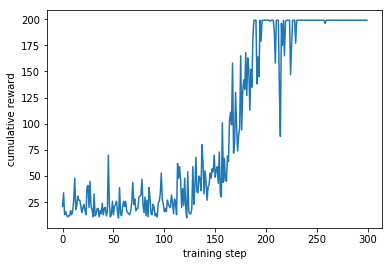

In [61]:
plt.xlabel('training step')
plt.ylabel('cumulative reward')
plt.plot(reward_set)
plt.show()

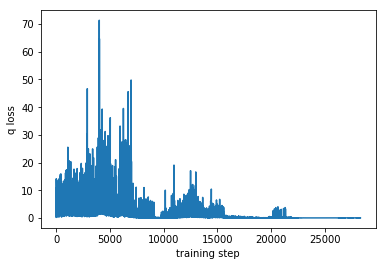

In [62]:
plt.xlabel('training step')
plt.ylabel('q loss')
plt.plot(q_loss_set)
plt.show()

### 参考资料

[1] [Simple Reinforcement Learning in Tensorflow: Part 1 - Two-armed Bandit](https://medium.com/@awjuliani/super-simple-reinforcement-learning-tutorial-part-1-fd544fab149)

[2][Simple Reinforcement Learning with Tensorflow Part 1.5: Contextual Bandits](https://medium.com/emergent-future/simple-reinforcement-learning-with-tensorflow-part-1-5-contextual-bandits-bff01d1aad9c)

[3][Simple Reinforcement Learning with Tensorflow: Part 2 - Policy-based Agents](https://medium.com/@awjuliani/super-simple-reinforcement-learning-tutorial-part-2-ded33892c724)

[4]Sutton R S, Barto A G. Reinforcement learning: An introduction[M]. MIT press, 2018.

## 3 Model-Based RL

在本小节，我们对环境进行显式建模，做法是通过一个神经网络去学习实际环境的动态响应过程。以前一小节的CartPole为例，给定任意时刻的竖杆位置和拟执行的动作，我们希望构建模型预测竖杆的下个位置，显然这本身环境应该反馈的信息，现在我们准备提前获知，通过学习只有一个模型，我们可以基于模型而不是外界环境去训练智能体。在CartPole的案例中或许体现不出Model-Based的好处，因为其环境本就是模拟的，但在实际物理世界中，拥有一个环境的等价模型可为训练节省大量成本。

不同于仿真，物理世界需要花大量时间去探索，此外，在物理世界，连仿真复位这一基本操作都无法实现，这些都毫无疑问加大训练难度。而构建物理时间的模型就可以节省那些不必要的花费。借助环境模型，智能体得以预知其执行动作在虚拟环境中的结果，此时可以基于虚拟的环境模型和实际环境进行训练。当然，如果我们构造的环境模型足够真实精准，智能体也可以完全在这虚拟环境中训练，然后直接投入真实物理实际应用（交通信号控制案例可以考虑）。


下面主要基于TensforFlow实现Model学习,结合AC训练的模型进行决策。依旧以CartPole为案例：

In [ ]:
import tensorflow as tf
import tensorflow.contrib.slim as slim
import numpy as np
import gym
import matplotlib.pyplot as plt
%matplotlib inline

np.random.seed(2)
tf.set_random_seed(2)  # reproducible
env = gym.make('CartPole-v0')
env.seed(1)  # reproducible
state_dim = env.observation_space.shape[0]
action_dim = env.action_space.n

In [66]:
class simEnv():
    def __init__(self,action_dim=2,state_dim=4):
        self.input_dim = action_dim+state_dim
        self.state_dim = state_dim
        self.input_holder = tf.placeholder(tf.float32, [None,self.input_dim],'sim_input')
        self.state_target =  tf.placeholder(tf.float32, [None,self.state_dim],'sim_next_state')
        self.done_target = tf.placeholder(tf.float32,[None,1],'sim_done')
        self.reward_target = tf.placeholder(tf.float32,[None,1],'sim_reward')
    
    def buildModel(self,):
        hidden_size = 12
        w1 = weight_variable([self.input_dim,hidden_size])
        b1 = bias_variable([hidden_size])
        h1 = tf.nn.elu(tf.matmul(self.input_holder, w1)+b1)
        
        w_next_state = weight_variable([hidden_size,self.state_dim])
        b_next_state = bias_variable([self.state_dim])
        next_state = tf.identity(tf.matmul(h1, w_next_state)+b_next_state)
        
        w_done = weight_variable([hidden_size,1])
        b_done = bias_variable([1])
        done = tf.sigmoid(tf.matmul(h1, w_done)+b_done)
        
        w_reward = weight_variable([hidden_size,1])
        b_reward = bias_variable([1])
        reward = tf.nn.elu(tf.matmul(h1, w_reward)+b_reward)
        
        self.prediction = tf.concat([next_state, done, reward],1)
        
        self.state_loss = tf.reduce_mean(tf.squared_difference(next_state, self.state_target))
        self.done_loss = -tf.reduce_mean(tf.log(tf.multiply(done,self.done_target)+tf.multiply(1-done, 1-self.done_target)))
        self.reward_loss = tf.reduce_mean(tf.squared_difference(reward, self.reward_target))
        
        self.loss = tf.reduce_mean(self.state_loss+self.done_loss+self.reward_loss)
        self.trainOp = tf.train.AdamOptimizer(learning_rate=0.001).minimize(self.loss)

In [67]:
class envMemory():
    def __init__(self, memory_capacity, state_dim, action_dim=2):
        self.state_dim=state_dim
        self.action_dim = action_dim
        self.memory_capacity = memory_capacity
        self.memory = np.zeros((self.memory_capacity, self.state_dim*2+self.action_dim+1+1))   # state, action ,reward ,next state, action index,q，target q
        self.pointer = 0
        
    def store_experience(self, input_, reward, next_state,done):
        index = self.pointer%self.memory_capacity
        experience  = np.hstack((input_, next_state,reward,done))
        self.memory[index,:]=experience
        self.pointer+=1
        
    def replay(self,batch_size):
        memory_batch = []
        for i in range(batch_size):
            index = np.random.randint(0,self.memory_capacity)
            memory_batch.append(self.memory[index,:])
        return np.array(memory_batch) 

In [69]:
sess2 = tf.Session()
sim_env = simEnv()
sim_env.buildModel()
init_op = tf.group(tf.global_variables_initializer(), tf.local_variables_initializer())
sess2.run(init_op)
M_env = envMemory(memory_capacity=3000, state_dim=4)

batch_size_ = 32
num_episodes = 300
records = 0
for i in range(num_episodes):
    s = env.reset()
    max_step=199
    j=0
    while j<=max_step:
        
        a_output = sess_.run(model.action_output, feed_dict={model.state:[s]})
        a = [np.random.choice(np.arange(a_output.shape[1]), p = a_output.ravel())]
        s_next,r,d,_ = env.step(a[0])
        if a==0:
            input_ = list(s)+[0,1]
        else:
            input_ = list(s)+[1,0]
        if d==True:
            d_=1
            
        else:
            d_=0

        M_env.store_experience(input_=input_, next_state = s_next,reward=[r],done=[d_])
        
        records+=1
        s = s_next
        
        if records>M_env.memory_capacity:
            memory_batch = M_env.replay(batch_size=batch_size_)
            train_s =  memory_batch[:,0:M_env.state_dim+M_env.action_dim]
            train_ns = memory_batch[:,M_env.state_dim+M_env.action_dim:2*M_env.state_dim+M_env.action_dim]
            train_r = memory_batch[:,-2].reshape(-1,1)
            train_d = memory_batch[:,-1].reshape(-1,1)
            _,l1,l2,l3 = sess2.run([sim_env.trainOp,sim_env.state_loss,sim_env.done_loss,sim_env.reward_loss], 
                                   feed_dict={sim_env.input_holder :train_s, 
                                              sim_env.state_target :train_ns ,
                                              sim_env.reward_target :train_r , 
                                              sim_env.done_target :train_d})
        
            if records%100==0:
                print('state loss:%g || reward loss:%g || done loss:%g'%(l1 ,l2 ,l3 ))
        j+=1
        if d==True:break


state loss:0.0528775 || reward loss:0.540797 || done loss:0.105846
state loss:0.0473918 || reward loss:0.287016 || done loss:0.00503898
state loss:0.0339447 || reward loss:0.152665 || done loss:0.00196927
state loss:0.035955 || reward loss:0.0864467 || done loss:0.000461894
state loss:0.0313962 || reward loss:0.049298 || done loss:0.000332367
state loss:0.0292789 || reward loss:0.0331376 || done loss:0.000146531
state loss:0.0360872 || reward loss:0.269421 || done loss:6.50384e-05
state loss:0.0265735 || reward loss:0.0187625 || done loss:3.98919e-05
state loss:0.0272185 || reward loss:0.0147039 || done loss:5.72026e-06
state loss:0.0253808 || reward loss:0.0120447 || done loss:5.42153e-06
state loss:0.0287259 || reward loss:0.150751 || done loss:7.57771e-06
state loss:0.0248633 || reward loss:0.00892373 || done loss:4.46798e-06
state loss:0.0234784 || reward loss:0.164692 || done loss:5.9017e-06
state loss:0.0253845 || reward loss:0.00659367 || done loss:4.9972e-06
state loss:0.023289

state loss:0.0214169 || reward loss:0.00625996 || done loss:4.71909e-06
state loss:0.0143469 || reward loss:0.00461753 || done loss:4.60239e-06
state loss:0.0196208 || reward loss:0.0039983 || done loss:1.88398e-06
state loss:0.0240339 || reward loss:0.00423096 || done loss:2.10363e-06
state loss:0.0256716 || reward loss:0.192438 || done loss:7.40315e-06
state loss:0.0238172 || reward loss:0.00515711 || done loss:3.47115e-06
state loss:0.0176205 || reward loss:0.00532855 || done loss:3.82052e-06
state loss:0.0240608 || reward loss:0.00423545 || done loss:2.09015e-06
state loss:0.0239643 || reward loss:0.00462925 || done loss:5.13821e-06
state loss:0.0219137 || reward loss:0.00526804 || done loss:5.70533e-06
state loss:0.0256561 || reward loss:0.00444755 || done loss:7.80645e-06
state loss:0.0232398 || reward loss:0.00547587 || done loss:8.53427e-06
state loss:0.0186565 || reward loss:0.0046188 || done loss:5.82174e-06
state loss:0.0207575 || reward loss:0.00547601 || done loss:4.60451e

state loss:0.0237382 || reward loss:0.00489325 || done loss:2.28363e-06
state loss:0.0168696 || reward loss:0.00527001 || done loss:7.73706e-06
state loss:0.019092 || reward loss:0.00479177 || done loss:2.79758e-07
state loss:0.027387 || reward loss:0.00398557 || done loss:4.96927e-07
state loss:0.0186087 || reward loss:0.00479234 || done loss:2.2456e-06
state loss:0.0199276 || reward loss:0.00360638 || done loss:2.76062e-06
state loss:0.0295786 || reward loss:0.178633 || done loss:2.93919e-06
state loss:0.0266919 || reward loss:0.00433228 || done loss:3.92104e-06
state loss:0.0196029 || reward loss:0.00447585 || done loss:4.36439e-07
state loss:0.0218562 || reward loss:0.0048148 || done loss:7.98477e-07
state loss:0.0269041 || reward loss:0.165879 || done loss:2.3933e-06
state loss:0.0180998 || reward loss:0.00524547 || done loss:1.82951e-06
state loss:0.0206819 || reward loss:0.284577 || done loss:2.47813e-06
state loss:0.0206461 || reward loss:0.00501242 || done loss:2.90515e-06
sta

state loss:0.0212116 || reward loss:0.00492927 || done loss:1.79489e-06
state loss:0.0228171 || reward loss:0.00526656 || done loss:1.19887e-06
state loss:0.0284147 || reward loss:0.00478513 || done loss:1.33216e-06
state loss:0.0276161 || reward loss:0.00481795 || done loss:2.45637e-06
state loss:0.0219784 || reward loss:0.00358146 || done loss:2.03239e-06
state loss:0.0200367 || reward loss:0.147016 || done loss:3.7911e-06
state loss:0.0265811 || reward loss:0.00454637 || done loss:2.65254e-06
state loss:0.027657 || reward loss:0.121438 || done loss:3.33257e-06
state loss:0.0302881 || reward loss:0.00380576 || done loss:3.72053e-06
state loss:0.0225632 || reward loss:0.134301 || done loss:4.81782e-06
state loss:0.023374 || reward loss:0.00449756 || done loss:3.5496e-06
state loss:0.0219248 || reward loss:0.00542914 || done loss:3.45449e-06
state loss:0.0249751 || reward loss:0.00442524 || done loss:5.3627e-06
state loss:0.0234146 || reward loss:0.132769 || done loss:4.62653e-06
state

state loss:0.0204247 || reward loss:0.00366178 || done loss:2.92535e-06
state loss:0.0215201 || reward loss:0.00428004 || done loss:6.61676e-06
state loss:0.0231715 || reward loss:0.00467518 || done loss:4.19814e-06
state loss:0.0248411 || reward loss:0.00456012 || done loss:1.69796e-06
state loss:0.0301313 || reward loss:0.179755 || done loss:8.09883e-06
state loss:0.0222777 || reward loss:0.00426831 || done loss:9.06633e-07
state loss:0.0208861 || reward loss:0.00442259 || done loss:1.77865e-06
state loss:0.0239677 || reward loss:0.00517385 || done loss:2.23088e-06
state loss:0.0224145 || reward loss:0.162189 || done loss:2.73347e-06
state loss:0.0234555 || reward loss:0.00489554 || done loss:3.76497e-06
state loss:0.0190256 || reward loss:0.154749 || done loss:6.28592e-06
state loss:0.0276495 || reward loss:0.004128 || done loss:2.35438e-06
state loss:0.0205263 || reward loss:0.0051375 || done loss:4.01951e-06
state loss:0.0193897 || reward loss:0.00487951 || done loss:4.14035e-06
s

In [80]:
s = env.reset()
s_sim = s
done=False

sim_state_trainsistion=[]
state_transistion=[]
sim_reward_set=[]
reward_set=[]
sim_done_set=[]
done_set=[]

while done==False:
    a_output = sess_.run(model.action_output, feed_dict={model.state:[s]})
    a = [np.random.choice(np.arange(a_output.shape[1]), p = a_output.ravel())]
    s_next,r,d,_ = env.step(a[0])
    if a==0:
        input_ = list(s_sim)+[0,1]
    else:
        input_ = list(s_sim)+[1,0]
        
    sim = sess2.run(sim_env.prediction, feed_dict={sim_env.input_holder:[input_]})
    sim=sim[0]
    sim_done_set.append(sim[-2])
    sim_reward_set.append(sim[-1])
    sim_state_trainsistion.append(sim[0:4])
    
    done_set.append(d)
    reward_set.append(r)
    state_transistion.append(s_next)
    
    s=s_next
    s_sim = sim[0:4]
    done = d

<function matplotlib.pyplot.show(*args, **kw)>

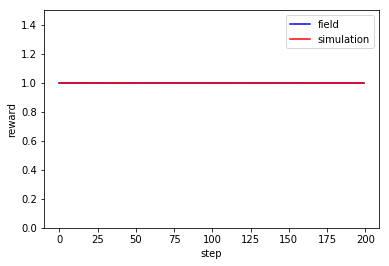

In [87]:
plt.ylim([0,1.5])
plt.xlabel('step')
plt.ylabel('reward')
plt.plot(reward_set,color='blue',label='field')
plt.plot(sim_reward_set,color='red',label='simulation')
plt.legend()  
plt.show

<function matplotlib.pyplot.show(*args, **kw)>

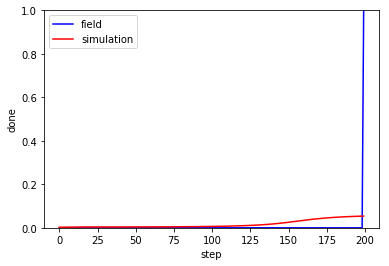

In [92]:
plt.ylim([0,1])
plt.xlabel('step')
plt.ylabel('done')
plt.plot(done_set,color='blue',label='field')
plt.plot(sim_done_set,color='red',label='simulation')
plt.legend()  
plt.show

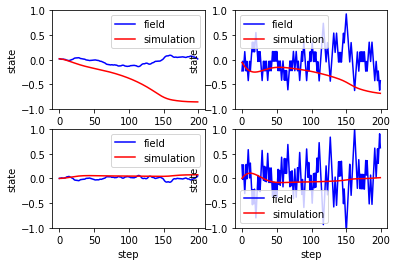

In [91]:
state_transistion = np.array(state_transistion)
sim_state_trainsistion = np.array(sim_state_trainsistion)

fig, ax = plt.subplots(nrows=2, ncols=2)
i=0
for row in ax:
    for col in row:
        col.set_ylim([-1,1])
        col.set_xlabel('step')
        col.set_ylabel('state')
        col.plot(state_transistion[:,i],color='blue',label='field')
        col.plot(sim_state_trainsistion[:,i],color='red',label='simulation')
        col.legend() 
        i+=1
plt.show()

### 参考资料

[1][Simple Reinforcement Learning with Tensorflow: Part 3 - Model-Based RL](https://medium.com/@awjuliani/simple-reinforcement-learning-with-tensorflow-part-3-model-based-rl-9a6fe0cce99)

## 4 More advanced DQN

在章节2回顾了DQN，实际上，强化学习的研究发展迅猛，2014年出现的DQN早已不再是最先进的智能体训练算法了。以下主要回顾近年来DQN两个比较著名的进化，Duble DQN和Dueling DQN：

### Double DQN

Double DQN的主要动机是克服DQN经常高估给定状态的潜在动作效益值，即高估Q值。DQN的这一问题往往使得某一局部最优的动作的Q值常规性地大于最优动作的Q值，导致智能体无法学习出一个足够理想的策略。为了解决这个问题，Double DQN提出将训练过程中求目标Q值的最大化操作拆分为动作筛选和动作评估两个过程，即目标Q值计算如下：

**Eq(7):** $Double\  DQN \ Target \ Q_t=r_t+ \lambda Q(s_{t+1},arg \mathop {\max }\limits_{a} (Q(s_{t+1},a|\theta) |\theta^{-}))$

我们知道，原DQN的目标值估计为：$DQN\ Target\ Q_t=r_t+ \lambda \mathop {\max }\limits_{a} (Q(s_{t+1},a| \theta^{-})$，通过对比可以发现，在Double DQN中，先利用训练网络根据贪心原则筛选Q值最大的动作，再用目标网络（冻结参数但定期更新）计算筛选后动作在给定状态的Q值。使得目标Q值的计算更加公平，不容易过早陷入局部最优。


### Dueling DQN

在Dueling DQN 中，状态-动作的效益值$Q(s,a)$被分解成两个基础值：

**Eq(8)**: $Q(s,a)=V(s)+A(a)$

其中,$V(s)$是状态评价，$A(a)$是动作评价。Dueling DQN构造网络如下图：

<center>
    <img style="border-radius: 0.3125em;
    box-shadow: 0 2px 4px 0 rgba(34,36,38,.12),0 2px 10px 0 rgba(34,36,38,.08);" 
    src="https://miro.medium.com/max/1050/1*N_t9I7MeejAoWlDuH1i7cw.png" height="300" width="300">
    <br>
    <div style="color:orange; border-bottom: 1px solid #d9d9d9;
    display: inline-block;
    color: #999;
    padding: 2px;">DQN（上）与Dueling DQN网络（下）对比示意图</div>
</center>

可以看到，Dueling DQN的倒数第二层输出分成了状态价值函数估计和动作优势估计两部分，然后将计算结果组合输入最后一层得到最终Q值。这种做法的考虑是，有很多场景动作并不影响所处状态的价值，比如智能体被包围且无论从哪个位置攻击包围圈都无法突围，此时就不需要再去评价各个状态-动作对的价值了。

#### Double-Dueling DQN in Tensorflow:

In [137]:
import tensorflow as tf
import tensorflow.contrib.slim as slim
import numpy as np
import gym
import matplotlib.pyplot as plt
%matplotlib inline

np.random.seed(2)
tf.set_random_seed(2)  # reproducible
env = gym.make('CartPole-v0')
env.seed(1)  # reproducible
state_dim = env.observation_space.shape[0]
action_dim = env.action_space.n

In [221]:
class replay_memory():
    def __init__(self, memory_capacity, state_dim, action_dim=1):
        self.memory_capacity = memory_capacity
        self.memory = np.zeros((self.memory_capacity, 2*state_dim+1+1))  
        self.pointer = 0
        
    def store_experience(self, state,action,next_sate,reward):
        index = self.pointer%self.memory_capacity
        experience  = np.hstack((state,action,next_sate,reward))
        self.memory[index,:]=experience
        self.pointer+=1
        
    def replay(self,batch_size):
        memory_batch = []
        for i in range(batch_size):
            index = np.random.randint(0,self.memory_capacity)
            memory_batch.append(self.memory[index,:])
        return memory_batch 

In [241]:
def weight_variable(shape,train=True):
    initial = tf.truncated_normal(shape, stddev=0.1)
    return tf.Variable(initial,trainable=train)
def bias_variable(shape,train=True):
    initial = tf.truncated_normal(shape, stddev=0.1)
    return tf.Variable(initial,trainable=train)


class DoubleDuelingDQN():
    def __init__(self,  sess, state_dim=4, action_dim=2, lamda=0.95, updateStep=200, output_num=2):
        self.state_dim = state_dim
        self.action_dim = action_dim
        self.state = tf.placeholder(tf.float32,[None,self.state_dim],name='state')
        self.next_state = tf.placeholder(tf.float32,[None,self.state_dim],name='next_state')
        self.action_index = tf.placeholder(tf.int32, [None], name='a')
        self.lamda = lamda
        self.updateStep = updateStep
        self.output_num = output_num
        self.sess = sess
        self.reward_holder = tf.placeholder(tf.float32,[None,1],name='reward')
        self.targetQ_holder = tf.placeholder(tf.float32,[None,1],name='target')
        
    def buildQNetwork(self,):
        hidden_size=16
        with tf.variable_scope('update-Qnetwork'):
            
            w1 = weight_variable([self.state_dim,hidden_size])
            b1 = bias_variable([hidden_size])
            w_s = weight_variable([hidden_size,1])
            b_s = bias_variable([1])
            w_a = weight_variable([hidden_size,self.action_dim])
            b_a = bias_variable([self.action_dim])
            
        with tf.variable_scope('target-Qnetwork'):
            w1_ = weight_variable([self.state_dim,hidden_size],train=False)
            b1_ = bias_variable([hidden_size],train=False)
            w_s_ = weight_variable([hidden_size,1],train=False)
            b_s_ = bias_variable([1],train=False)
            w_a_ = weight_variable([hidden_size,self.action_dim],train=False)
            b_a_ = bias_variable([self.action_dim],train=False)
                                
        self.e_params = tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES, scope='update-Qnetwork')
        self.t_params = tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES, scope='target-Qnetwork')
                                
        self.h1 = tf.nn.elu(tf.matmul(self.state, w1)+b1)
        self.vs = (tf.matmul(self.h1,w_s)+b_s)
        self.advantage = (tf.matmul( self.h1,w_a)+b_a)
        self.Qs = self.vs + tf.subtract(self.advantage,tf.reduce_mean(self.advantage,axis=1,keep_dims=True))
        self.action_choose = tf.argmax(self.Qs,1)
        
        # next Q value produce
        h1_eva = tf.nn.elu(tf.matmul(self.next_state, w1)+b1)
        vs_eva = (tf.matmul(h1_eva,w_s)+b_s)
        advantage_eva = (tf.matmul(h1_eva,w_a)+b_a)
        Qs_eva = vs_eva + tf.subtract(advantage_eva,tf.reduce_mean(advantage_eva,axis=1,keep_dims=True))
        action_choose_eva = tf.argmax(Qs_eva,1)     
        
        h1_next = tf.nn.elu(tf.matmul(self.next_state, w1_)+b1_)
        vs_next = (tf.matmul(h1_next,w_s_)+b_s_)
        advantage_next = (tf.matmul(h1_next,w_a_)+b_a_)
        Qs_next = vs_next + tf.subtract(advantage_next, tf.reduce_mean(advantage_next,axis=1,keep_dims=True))
        self.nextQ = Qs_next[0,action_choose_eva[0]]
        
        increasing = tf.range(start=0, limit=tf.shape(self.action_index)[0], delta=1)
        mask = tf.stack([increasing, self.action_index], axis=1)
        self.Q = tf.gather_nd(self.Qs, mask)
        
        self.targetQ = self.reward_holder+self.lamda*self.nextQ
        
        self.loss = tf.reduce_mean(tf.squared_difference(self.targetQ_holder, self.Q))
        
        self.trainOp = tf.train.AdamOptimizer(learning_rate=0.002).minimize(self.loss)
    
    def learn(self,step,memory):
        
        _, loss = self.sess.run([self.trainOp,self.loss], feed_dict={self.state : memory[:,0:self.state_dim], 
                                                                     self.action_index : memory[:,self.state_dim].reshape(-1,), 
                                                                     self.next_state : memory[:,-self.state_dim-1:-1],
                                                                     self.reward_holder:memory[:,-2].reshape(-1,1),
                                                                     self.targetQ_holder:memory[:,-1].reshape(-1,1)})
        
        if step%self.updateStep==0:
            self.sess.run([tf.assign(tar,  eva) for tar, eva in zip(self.t_params, self.e_params)])
        return loss
    
    def choose_action(self,state,epsilon=0.9):
        if np.random.uniform() < epsilon:
            return [np.random.randint(0, 2)]
        else:
            return self.sess.run(self.action_choose, feed_dict={self.state:state})

        
class replay_memory():
    def __init__(self, memory_capacity, state_dim, action_dim=1):
        self.memory_capacity = memory_capacity
        self.memory = np.zeros((self.memory_capacity, 2*4+1+1+1))  
        self.pointer = 0
        
    def store_experience(self, state, action, next_sate,reward,target):
        index = self.pointer%self.memory_capacity
        experience  = np.hstack((state, action, next_sate,reward,target))
        self.memory[index,:]=experience
        self.pointer+=1
        
    def replay(self,batch_size):
        memory_batch = []
        for i in range(batch_size):
            index = np.random.randint(0,self.memory_capacity)
            memory_batch.append(self.memory[index,:])
        return memory_batch        
    
    
tf.reset_default_graph()
sess_ = tf.Session()
model = DoubleDuelingDQN(state_dim=4, lamda=0.95,updateStep=200, sess=sess_)
model.buildQNetwork()
init_op = tf.group(tf.global_variables_initializer(), tf.local_variables_initializer())
sess_.run(init_op)

M = replay_memory(memory_capacity=500, state_dim=state_dim_)
batch_size_ = 32
num_episodes = 1500

records = 0
loss_set=[]
reward_set=[]
flag=0

e=0.9

for i in range(num_episodes):
    s = env.reset()
    rewards=0
    if i>350:
        e=-1
    aset=[]
    j=0
    while True:
        a = model.choose_action(state=[s],epsilon=e)
        aset.append(a[0])
        s_next, r, d,_ = env.step(a[0])
        
        tq = sess_.run(model.targetQ,feed_dict={model.state:[s],model.next_state:[s_next],model.reward_holder:[[r]]})

        M.store_experience(state=s, action=a, next_sate=s_next, reward=[r],target=tq[0])

        records+=1
        rewards+=r
        
        if records>M.memory_capacity:
            if flag==0:
                flag=1
            memory_batch = M.replay(batch_size=batch_size_)
            loss_ = model.learn(records,memory=np.array(memory_batch) )
            loss_set.append(loss_)
            
        if d==True:
            break
        s = s_next
        j+=1
        
    if flag==1:
        print('train-- episode:%d'%i)
        flag = 2 
    if i%20==0 and records>M.memory_capacity:
        print('num_episodes:%d lasting:%d loss:%g'%(i,j,loss_))
            
    reward_set.append(rewards)
    


train-- episode:22
num_episodes:40 lasting:24 loss:0.235224
num_episodes:60 lasting:15 loss:0.139002
num_episodes:80 lasting:12 loss:0.108001
num_episodes:100 lasting:25 loss:0.086231
num_episodes:120 lasting:15 loss:0.103926
num_episodes:140 lasting:27 loss:0.0843554
num_episodes:160 lasting:19 loss:0.128462
num_episodes:180 lasting:10 loss:0.0875038
num_episodes:200 lasting:11 loss:0.0631162
num_episodes:220 lasting:8 loss:0.0613738
num_episodes:240 lasting:64 loss:0.0511256
num_episodes:260 lasting:18 loss:0.0437962
num_episodes:280 lasting:15 loss:0.0538459
num_episodes:300 lasting:16 loss:0.0315067
num_episodes:320 lasting:21 loss:0.0251302
num_episodes:340 lasting:19 loss:0.0291074
num_episodes:360 lasting:11 loss:0.0209513
num_episodes:380 lasting:9 loss:0.0178951
num_episodes:400 lasting:29 loss:0.0255998
num_episodes:420 lasting:16 loss:0.0107251
num_episodes:440 lasting:35 loss:0.0191567
num_episodes:460 lasting:42 loss:0.0174476
num_episodes:480 lasting:31 loss:0.00878739
nu

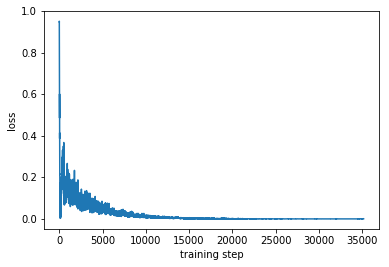

In [242]:
plt.plot(loss_set)
plt.xlabel('training step')
plt.ylabel('loss')
plt.show()

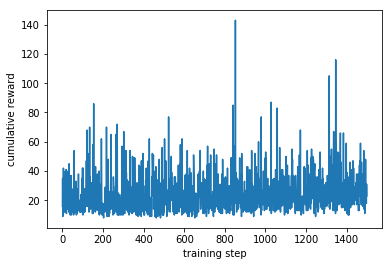

In [243]:
plt.plot(reward_set)
plt.xlabel('training step')
plt.ylabel('cumulative reward')
plt.show()

In [240]:
print(sess_.run(model.Qs,feed_dict={model.state:[s]}))

[[19.89064  19.891525]]


### 参考资料

[1][Simple Reinforcement Learning with Tensorflow Part 4: Deep Q-Networks and Beyond](https://medium.com/@awjuliani/simple-reinforcement-learning-with-tensorflow-part-4-deep-q-networks-and-beyond-8438a3e2b8df)

[2][Deep Reinforcement Learning with Double Q-learning](https://arxiv.org/abs/1509.06461)

[3][Dueling Network Architectures for Deep Reinforcement Learning](https://arxiv.org/abs/1511.06581)

# 5 Deep Deterministic Policy Gradient

在之前回顾的梯度策略下降算法，包括相应的actor-critic中，策略被参数化成一个概率分布，即选择每个动作被一个概率分布控制，并不是直接确定选择一个动作，这为智能体学习带来一定的探索能力的同时，更多的是导致训练误差的方差增大，增大学习难度，此外，原来的策略梯度算法只能解决动作离散的问题，但动作空间过高或连续，收敛效果急剧下降，甚至根本无法应用。为了提高学习效率和强化学习的应用范围，学者提出了确定策略梯度算法，直接构造策略函数，根据状态映射出一个确定的动作。具体的算法推导见[3]。下面是其具体的更新定理：

将策略函数写作：$a=\mu_{\theta}(s)$

则 $J_{\theta}(s)=\int_{S} p(s)V^{\mu_{\theta}(s)}(s)ds$ 可表示该策略下对应问题的总的期望收益，智能体训练的目的就是求得一个使期望收益尽可能大的策略，依旧采用梯度上升的方法，更新梯度如下：

$\bigtriangledown J_{\theta}(s)=E_{s \sim p^{\mu}}[\bigtriangledown_{\theta}\mu_{\theta}(s)\bigtriangledown_{a}Q^{\mu}(s,a)|_{a=\mu_{\theta}(s)}]$

利用该定理，可以将Actor-Critic改进成确定梯度策略下降的版本：

In [129]:
import tensorflow as tf
import tensorflow.contrib.slim as slim
import numpy as np
import gym
import matplotlib.pyplot as plt
%matplotlib inline

np.random.seed(2)
tf.set_random_seed(2)  # reproducible
env = gym.make('CartPole-v0')
env.seed(1)  # reproducible
state_dim = env.observation_space.shape[0]
action_dim = env.action_space.n

In [130]:
def weight_variable(shape,train=True):
    initial = tf.truncated_normal(shape, stddev=0.5)
    return tf.Variable(initial,trainable=train)
def bias_variable(shape,train=True):
    initial = tf.constant(value=0.1,shape=shape)
    return tf.Variable(initial,trainable=train)

class agent():
    def __init__(self, action_dim=1, state_dim=4 ):
        self.state_dim = state_dim
        self.action_dim = action_dim
        self.state_holder = tf.placeholder(tf.float32,[None,state_dim], name='state')
        self.next_state_holder = tf.placeholder(tf.float32,[None,state_dim], name='next_state')
        self.reward_holder = tf.placeholder(tf.float32,[None,1], name='reward')
        
    def buildCriticNetwork(self,):
        with tf.variable_scope('update-Critic_network'):
            ws = weight_variable([self.state_dim, 1])
            wa = weight_variable([self.action_dim, 1])
            wc = weight_variable([1,1])
            b1 = bias_variable([1])
        with tf.variable_scope('target-Critic_network'):
            ws_ = weight_variable([self.state_dim, 1],train=False)
            wa_ = weight_variable([self.action_dim, 1],train=False)
            wc_ = weight_variable([1,1],train=False)
            b1_ = bias_variable([1],train=False) 
            
        self.q_e_params = tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES, scope='update-Critic_network')
        self.q_t_params = tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES, scope='target-Critic_network')
        
        self.a = tf.stop_gradient(self.action_output)  # action output for Q vaue estimation should act only as constant input
        
        
        h1 = tf.nn.elu(tf.matmul(self.state_holder, ws))
        h2 = tf.nn.elu(tf.matmul(self.action_output, wa))
        
        self.Q = tf.nn.elu(tf.matmul(h1+h2,wc)+b1)

        h1_ = tf.nn.elu(tf.matmul(self.next_state_holder, ws_))
        h2_ = tf.nn.elu(tf.matmul(self.next_action_output, wa_))
        self.Qnext = tf.nn.elu(tf.matmul(h1_+h2_,wc_)+b1_)
        
        self.targetQ = self.reward_holder + 0.9*self.Qnext
        
        self.q_loss = tf.reduce_mean(tf.squared_difference(self.targetQ, self.Q))
        
        self.q_trainOp = tf.train.AdamOptimizer(learning_rate=0.0001).minimize(self.q_loss)
        
        self.q_grads_a = tf.gradients(self.Q,self.action_output)[0]
        
        self.Critic_network_update=[tf.assign(tar, eva) for tar, eva in zip(self.q_t_params, self.q_e_params)]
        
    def buildActorNetwork(self, ):
        with tf.variable_scope('update-Actor_network'):
            w1 = weight_variable([self.state_dim, 1])
            b1 = bias_variable([1])
            
        with tf.variable_scope('target-Actor_network'):
            w1_ = weight_variable([self.state_dim, 1],train=False)
            b1_ = bias_variable([1],train=False)
            
        self.p_e_params = tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES, scope='update-Actor_network')
        self.p_t_params = tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES, scope='target-Actor_network')
        
        self.action_output = tf.nn.elu(tf.matmul(self.state_holder, w1)+b1)
     
        self.next_action_output = tf.nn.elu(tf.matmul(self.next_state_holder, w1_)+b1_)
   
        self.Actor_network_update=[tf.assign(tar, eva) for tar, eva in zip(self.p_t_params, self.p_e_params)]
        
    def add_Q_grad_to_graph(self,):
        self.policy_grads = tf.gradients(ys=self.action_output, xs=self.p_e_params, grad_ys=self.q_grads_a)
        opt = tf.train.AdamOptimizer(learning_rate= -0.0002) 
        self.p_trainOp = opt.apply_gradients(zip(self.policy_grads, self.p_e_params))


In [131]:
class replay_memory():
    def __init__(self, memory_capacity, state_dim, action_dim=1):
        self.memory_capacity = memory_capacity
        self.memory = np.zeros((self.memory_capacity, 2*state_dim+action_dim+1))   # state, action ,reward ,next state, action index,q，target q
        self.pointer = 0
        
    def store_experience(self, state, action, reward, next_sate):
        index = self.pointer%self.memory_capacity
        experience  = np.hstack((state, action, reward, next_sate))
        self.memory[index,:]=experience
        self.pointer+=1
        
    def replay(self,batch_size):
        memory_batch = []
        for i in range(batch_size):
            index = np.random.randint(0,self.memory_capacity)
            memory_batch.append(self.memory[index,:])
        return np.array(memory_batch)

In [132]:
M = replay_memory(memory_capacity=800, state_dim=4, action_dim=1)
batch_size_ = 32
num_episodes = 400
updateStep=6

tf.reset_default_graph()
sess_ = tf.Session()
model = agent( )

model.buildActorNetwork()
model.buildCriticNetwork()
model.add_Q_grad_to_graph()
init_op = tf.group(tf.global_variables_initializer(), tf.local_variables_initializer())
sess_.run(init_op)
records = 0
reward_set=[]
q_loss_set=[]
flag=0
max_steps_in_episode = 199 # CartPole-v0默认的最大episode是200，为了防止正确的移动却带来坏的奖赏，将实验的最大episode设为199
asets=[]
for i in range(num_episodes):
    rewards=0
    s = env.reset()
    j = 0
    aset=[]
    while j<max_steps_in_episode:
        a_output = sess_.run(model.action_output, feed_dict={model.state_holder:[s]})
#         a = round(np.clip(a_output[0][0],0,1))
#         if i <100:
        a = round(np.clip(np.random.normal(a_output[0][0], 0.1), 0, 1))
        aset.append(a)
        s_next, r, d, _ = env.step(int(a))
          
        j+=1
        records+=1
        rewards+=r
        
        if d==True:
            r=-10
        
        if records>M.memory_capacity:
            memory_batch = M.replay(batch_size=batch_size_)
            train_s =  memory_batch[:,0:model.state_dim]
            train_a = memory_batch[:,model.state_dim]
            train_r = memory_batch[:,model.state_dim+1].reshape(-1,1)
            train_ns = memory_batch[:,-model.state_dim:]

            _,_,q_loss  = sess_.run([model.p_trainOp, model.q_trainOp, model.q_loss], 
                                   feed_dict={model.state_holder :train_s, 
                                              model.reward_holder :train_r , 
                                              model.next_state_holder :train_ns})   

            q_loss_set.append(q_loss)
                    
            if flag==0:
                flag=1
                print('train...')
            if records%updateStep==0:
                sess_.run(model.Actor_network_update)
                sess_.run(model.Critic_network_update)
                
        M.store_experience(state=s, action=[a], reward=[r], next_sate=s_next)

        if d==True:
            break
            
        s = s_next
    asets.append(aset)   
    print('num_episodes:%d lasting:%d'%(i,j))
    
    reward_set.append(rewards)



num_episodes:0 lasting:25
num_episodes:1 lasting:28
num_episodes:2 lasting:15
num_episodes:3 lasting:17
num_episodes:4 lasting:18
num_episodes:5 lasting:17
num_episodes:6 lasting:23
num_episodes:7 lasting:20
num_episodes:8 lasting:20
num_episodes:9 lasting:19
num_episodes:10 lasting:26
num_episodes:11 lasting:28
num_episodes:12 lasting:24
num_episodes:13 lasting:24
num_episodes:14 lasting:18
num_episodes:15 lasting:16
num_episodes:16 lasting:20
num_episodes:17 lasting:26
num_episodes:18 lasting:26
num_episodes:19 lasting:23
num_episodes:20 lasting:27
num_episodes:21 lasting:26
num_episodes:22 lasting:28
num_episodes:23 lasting:15
num_episodes:24 lasting:16
num_episodes:25 lasting:20
num_episodes:26 lasting:27
num_episodes:27 lasting:23
num_episodes:28 lasting:20
num_episodes:29 lasting:21
num_episodes:30 lasting:24
num_episodes:31 lasting:20
num_episodes:32 lasting:23
num_episodes:33 lasting:27
num_episodes:34 lasting:29
train...
num_episodes:35 lasting:28
num_episodes:36 lasting:25
nu

num_episodes:305 lasting:10
num_episodes:306 lasting:10
num_episodes:307 lasting:9
num_episodes:308 lasting:8
num_episodes:309 lasting:9
num_episodes:310 lasting:10
num_episodes:311 lasting:10
num_episodes:312 lasting:9
num_episodes:313 lasting:9
num_episodes:314 lasting:9
num_episodes:315 lasting:9
num_episodes:316 lasting:10
num_episodes:317 lasting:9
num_episodes:318 lasting:10
num_episodes:319 lasting:8
num_episodes:320 lasting:9
num_episodes:321 lasting:9
num_episodes:322 lasting:9
num_episodes:323 lasting:9
num_episodes:324 lasting:9
num_episodes:325 lasting:11
num_episodes:326 lasting:9
num_episodes:327 lasting:10
num_episodes:328 lasting:10
num_episodes:329 lasting:8
num_episodes:330 lasting:9
num_episodes:331 lasting:9
num_episodes:332 lasting:11
num_episodes:333 lasting:9
num_episodes:334 lasting:10
num_episodes:335 lasting:8
num_episodes:336 lasting:8
num_episodes:337 lasting:10
num_episodes:338 lasting:8
num_episodes:339 lasting:10
num_episodes:340 lasting:10
num_episodes:3

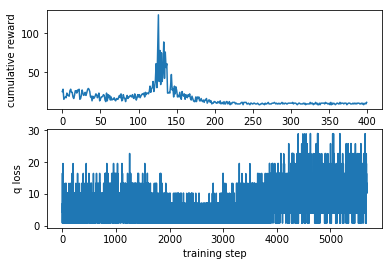

In [133]:
fig = plt.figure()

plt.subplot(2, 1, 1)
plt.xlabel('training episode')
plt.ylabel('cumulative reward')
plt.plot(reward_set)

plt.subplot(2, 1, 2)
plt.xlabel('training step')
plt.ylabel('q loss')
plt.plot(q_loss_set)

plt.show()

In [139]:
# 离散动作不稳定 试一下连续动作

import tensorflow as tf
import tensorflow.contrib.slim as slim
import numpy as np
import gym
import matplotlib.pyplot as plt
%matplotlib inline

np.random.seed(2)
tf.set_random_seed(2)  # reproducible
env = gym.make('Pendulum-v0')
env.seed(1)  # reproducible
action_bound = env.action_space.high

def weight_variable(shape,train=True):
    initial = tf.truncated_normal(shape, stddev=0.3)
    return tf.Variable(initial,trainable=train)
def bias_variable(shape,train=True):
    initial = tf.constant(value=0.1,shape=shape)
    return tf.Variable(initial,trainable=train)

class agent():
    def __init__(self,action_bound, action_dim=1, state_dim=3 ):
        self.state_dim = state_dim
        self.action_dim = action_dim
        self.state_holder = tf.placeholder(tf.float32,[None,state_dim], name='state')
        self.next_state_holder = tf.placeholder(tf.float32,[None,state_dim], name='next_state')
        self.reward_holder = tf.placeholder(tf.float32,[None,1], name='reward')
        self.action_bound = action_bound
    def buildCriticNetwork(self,):
        with tf.variable_scope('update-Critic_network'):
            ws = weight_variable([self.state_dim, 30])
            wa = weight_variable([self.action_dim,30])
            wc = weight_variable([30,1])
            b1 = bias_variable([30])
            b2 = bias_variable([1])
        with tf.variable_scope('target-Critic_network'):
            ws_ = weight_variable([self.state_dim, 30],train=False)
            wa_ = weight_variable([self.action_dim, 30],train=False)
            wc_ = weight_variable([30,1],train=False)
            b1_ = bias_variable([30],train=False) 
            b2_ = bias_variable([1],train=False)
            
        self.q_e_params = tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES, scope='update-Critic_network')
        self.q_t_params = tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES, scope='target-Critic_network')
        
#         self.a = tf.stop_gradient(self.action_output)  # action output for Q vaue estimation should act only as constant input
        
        
        h1 = (tf.matmul(self.state_holder, ws))
        h2 = (tf.matmul(self.action_output, wa))
        h3 = tf.nn.elu(h1+h2+b1)
        self.Q = tf.nn.elu(tf.matmul(h3, wc)+b2)

        h1_ = (tf.matmul(self.next_state_holder, ws_))
        h2_ = (tf.matmul(self.next_action_output, wa_))
        h3_ = tf.nn.elu(h1_+h2_+b1)
        self.Qnext = tf.nn.elu(tf.matmul(h3_, wc_)+b2_)
        
        self.targetQ = self.reward_holder + 0.9*self.Qnext
        
        self.q_loss = tf.reduce_mean(tf.squared_difference(self.targetQ, self.Q))
        
        self.q_trainOp = tf.train.AdamOptimizer(learning_rate=0.001).minimize(self.q_loss,var_list=self.q_e_params)
        
        self.q_grads_a = tf.gradients(self.Q,self.action_output)[0]
        
        self.Critic_network_update=[tf.assign(tar, eva) for tar, eva in zip(self.q_t_params, self.q_e_params)]
        
    def buildActorNetwork(self, ):
        with tf.variable_scope('update-Actor_network'):
            w1 = weight_variable([self.state_dim, 30])
            b1 = bias_variable([30])
            w2 = weight_variable([30, 1])
            b2 = bias_variable([1])
        with tf.variable_scope('target-Actor_network'):
            w1_ = weight_variable([self.state_dim, 30],train=False)
            b1_ = bias_variable([30],train=False)
            w2_ = weight_variable([30, 1],train=False)
            b2_ = bias_variable([1],train=False)
            
        self.p_e_params = tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES, scope='update-Actor_network')
        self.p_t_params = tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES, scope='target-Actor_network')
        
        self.h1 = tf.nn.elu(tf.matmul(self.state_holder, w1)+b1)
        self.action_output = tf.multiply(tf.nn.tanh(tf.matmul(self.h1, w2)+b2), self.action_bound)
     
        self.h1_ = tf.nn.elu(tf.matmul(self.next_state_holder, w1_)+b1_)
        self.next_action_output = tf.multiply(tf.nn.tanh(tf.matmul(self.h1_, w2_)+b2_), self.action_bound)
   
        self.Actor_network_update=[tf.assign(tar, eva) for tar, eva in zip(self.p_t_params, self.p_e_params)]
        
    def add_Q_grad_to_graph(self,):
        self.policy_grads = tf.gradients(ys=self.action_output, xs=self.p_e_params, grad_ys=self.q_grads_a)
        opt = tf.train.AdamOptimizer(learning_rate=-0.001) 
        self.p_trainOp = opt.apply_gradients(zip(self.policy_grads, self.p_e_params))
        
M = replay_memory(memory_capacity=10000, state_dim=3, action_dim=1)
batch_size_ = 32
num_episodes = 300
updateStep=600

tf.reset_default_graph()
sess_ = tf.Session()
model = agent(action_bound=action_bound )

model.buildActorNetwork()
model.buildCriticNetwork()
model.add_Q_grad_to_graph()
init_op = tf.group(tf.global_variables_initializer(), tf.local_variables_initializer())
sess_.run(init_op)
records = 0
reward_set=[]
q_loss_set=[]
flag=0
max_steps_in_episode = 300
asets=[]
var=3.
for i in range(num_episodes):
    rewards=0
    s = env.reset()
    j = 0
    aset=[]
    while j<max_steps_in_episode:
        a_output = sess_.run(model.action_output, feed_dict={model.state_holder:[s]})
        if i <200:
            a = np.clip(np.random.normal(a_output[0],var),-2,2)
        else:
            a = np.clip(a_output[0],-2,2)
        aset.append(a)
        s_next, r, d, _ = env.step(a)
          
        j+=1
        records+=1
        rewards+=r

        
        if records>M.memory_capacity:
            var *= .9995
            memory_batch = M.replay(batch_size=batch_size_)
            train_s =  memory_batch[:,0:model.state_dim]
            train_a = memory_batch[:,model.state_dim]
            train_r = memory_batch[:,model.state_dim+1].reshape(-1,1)
            train_ns = memory_batch[:,-model.state_dim:]

            _,_,q_loss  = sess_.run([model.p_trainOp, model.q_trainOp, model.q_loss], 
                                   feed_dict={model.state_holder :train_s, 
                                              model.reward_holder :train_r , 
                                              model.next_state_holder :train_ns})   

            q_loss_set.append(q_loss)
                    
            if flag==0:
                flag=1
                print('train...')
            if records%updateStep==0:
                sess_.run(model.Actor_network_update)
                sess_.run(model.Critic_network_update)
        
        M.store_experience(state=s, action=a, reward=[r/10.], next_sate=s_next)

        if d==True:
            break
            
        s = s_next
    asets.append(aset)   
    print('num_episodes:%d r:%d'%(i,rewards))
    
    reward_set.append(rewards)




num_episodes:0 r:-1646
num_episodes:1 r:-1555
num_episodes:2 r:-1597
num_episodes:3 r:-1756
num_episodes:4 r:-1565
num_episodes:5 r:-1739
num_episodes:6 r:-1646
num_episodes:7 r:-1735
num_episodes:8 r:-1377
num_episodes:9 r:-1625
num_episodes:10 r:-1388
num_episodes:11 r:-1519
num_episodes:12 r:-1735
num_episodes:13 r:-1611
num_episodes:14 r:-1476
num_episodes:15 r:-1745
num_episodes:16 r:-1767
num_episodes:17 r:-1628
num_episodes:18 r:-1579
num_episodes:19 r:-1645
num_episodes:20 r:-1776
num_episodes:21 r:-1581
num_episodes:22 r:-1363
num_episodes:23 r:-1759
num_episodes:24 r:-1613
num_episodes:25 r:-1620
num_episodes:26 r:-1665
num_episodes:27 r:-1721
num_episodes:28 r:-1553
num_episodes:29 r:-1464
num_episodes:30 r:-1448
num_episodes:31 r:-1607
num_episodes:32 r:-1328
num_episodes:33 r:-1489
num_episodes:34 r:-1586
num_episodes:35 r:-1602
num_episodes:36 r:-1536
num_episodes:37 r:-1569
num_episodes:38 r:-1561
num_episodes:39 r:-1610
num_episodes:40 r:-1327
num_episodes:41 r:-1728
nu

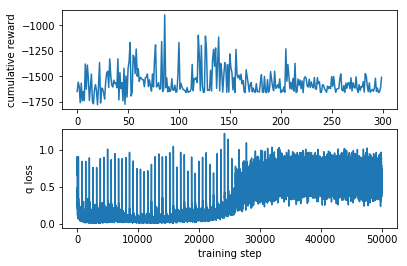

In [140]:
fig = plt.figure()

plt.subplot(2, 1, 1)
plt.xlabel('training episode')
plt.ylabel('cumulative reward')
plt.plot(reward_set)

plt.subplot(2, 1, 2)
plt.xlabel('training step')
plt.ylabel('q loss')
plt.plot(q_loss_set)

plt.show()

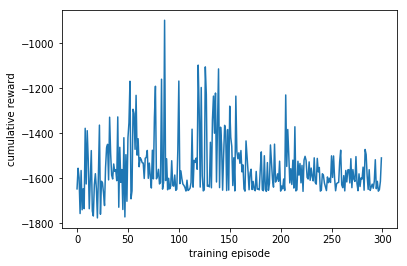

In [141]:
plt.xlabel('training episode')
plt.ylabel('cumulative reward')
plt.plot(reward_set)
plt.show()

### 参考资料

[1] [Deterministic Policy Gradient Algorithms](http://proceedings.mlr.press/v32/silver14.pdf)

[2] [Continuous Control With Deep Reinforcement Learning](https://arxiv.org/pdf/1509.02971.pdf)

[3][Deterministic Policy Gradient Algorithms: Supplementary Material](http://proceedings.mlr.press/v32/silver14-supp.pdf)

# 6 From Trust Religion Policy Optimization(TRPO) to Proximal Policy Optimization (PPO)

### 参考资料

[1][Trust Region Policy Optimization](https://arxiv.org/abs/1502.05477)

[2][Proximal Policy Optimization](https://openai.com/blog/openai-baselines-ppo/)

[3][RL — Trust Region Policy Optimization (TRPO) Explained](https://medium.com/@jonathan_hui/rl-trust-region-policy-optimization-trpo-explained-a6ee04eeeee9)

[4][RL — Proximal Policy Optimization (PPO) Explained](https://medium.com/@jonathan_hui/rl-proximal-policy-optimization-ppo-explained-77f014ec3f12)

# 7 Partial Observity and Deep Recurrent Q-Network

在实际应用问题中，更普遍的情况是我们不能对环境进行全感知，意味着智能体无法依据环境的所有信息去执行最优决策。我们把环境可以为智能体学习到最优决策提供所有必备信息的框架称为马尔可夫决策过程（MDP），而对只能提供部分信息的框架则被称为局部观察马尔可夫决策过程（Partially Observable Markov Decesion Process, POMDP）。

无法全感知的环境所提现的信息局部性分为空间局限和时间局限两种。空间局限指的是我们无法观察周围的全部状况，就好像人类无法同时观察前后然后决策；时间局限指的是我们任意时刻观察到的场景都是一个快照式的信息，唯有连续观察才能感知环境的变化动态，就好像乒乓球比赛中，在某时刻观察到球的动向不足以让我们执行好的应对决策，唯有观察球一段时间的移动，了解它反弹的角度和力度，才能执行正确的决策。

那么我们该如何构造出可以应对局部可观测的环境的智能体呢？其中一个关键是赋予智能体融合时间维度信息的能力。这个关键的动机是：某个时刻的观察结果往往无法提供有效的信息，而将观察时间拉长，足够的时变规律或许可成为更好的决策依据。

在经典的DQN文章中，作者采用叠加前四个时刻的帧作为智能体对环境的感知输入，这种构造在简单的游戏中获得不错的效果。但需要指出的是，这方法并完美:
- 首先，生硬地叠加不同时刻快照在生物角度并不可解释，因为生物观察外界时，并不是储备一段时间的信息再一下子可视化，即一段时间的信息被压缩在一瞬间回传到大脑；
- 其次，存储时间维度的信息往往会导致更多不必要的内存消耗，面对更复杂问题是该消耗会非常庞大；
- 最后，很关键的一点是一段时间的信息可能还不足以为决策提供最好的依据，因为某一决策可能受很久之前的环境状态影响。

为了优化和解决以上几个不足，学者提出了Deep Recurrent Q-Learning的强化学习框架，将递归神经网络移植到智能体上。借助递归神经网络部件，我们可以一次输入一个感知快照，然后递归神经网络会记忆依次传输进来的快照信息，结合递归神经网络隐藏状态的传递，感知时间维度的模式。简单来说，递归神经网络让智能体的每个时间节点的输入都串联起来，在任意时刻，智能体可以依据之前消化的观察信息做出合适的决策。

<center>
    <img style="border-radius: 0.3125em;
    box-shadow: 0 2px 4px 0 rgba(34,36,38,.12),0 2px 10px 0 rgba(34,36,38,.08);" 
    src="https://miro.medium.com/max/1050/1*aX8QjJP-gDXA4Dc3gP9LcQ.png" height="300" width="300">
    <br>
    <div style="color:orange; border-bottom: 1px solid #d9d9d9;
    display: inline-block;
    color: #999;
    padding: 2px;">DRQN:利用递归神经网络融合时间信息</div>
</center>

为了实现DRQN，可以在DQN的基础上进行以下的调整：

- 1）智能体对环境的感知引入时间维度信息：输入一定步数的状态快照，训练时：输入步数=自定义步数；应用时：输入步数=1.
- 2）experience replay调整：为考虑时间维度信息，适应递归神经网络的输入机制，以episode长度为单位存储信息，以输入步数为单位抽取经验，即每次存储数据的维度为：
                  [1,原存储经验大小 x episode长度 ]
每次训练抽取的数据时，先随机筛选一个存储的episode，再随机选取该episode的任意时刻作为起始时刻，以输入步数为单位得到一条训练样本，抽取样本的维度为:

                  [bacth size,原存储经验大小 x 输入步数 ]

     转化为rnn输入时，reshape为:

                   [bacth size x 输入步数,原存储经验大小]
- 3）更新梯度调整：在计算估计Q值和目标Q值的误差时，误差维度应为 [batch size, 输入步数] 参照[3]提出的优化策略，仅利用后一半输入步数的loss计算梯度，进行参数更新，此优化策略有待进一步分析探究。

### DRQN in Tensorflow

In [1]:
import tensorflow as tf
import gym
import numpy as np
import random
import matplotlib.pyplot as plt
%matplotlib inline
env = gym.make('FrozenLake-v0')

episode: 520 loss: 0.0478551
episode: 540 loss: 0.074875
episode: 560 loss: 0.0371069
episode: 580 loss: 0.0375996
episode: 600 loss: 0.047736
episode: 620 loss: 0.0326014
episode: 640 loss: 0.0406121
episode: 660 loss: 0.0172501
episode: 680 loss: 0.0390557
episode: 700 loss: 0.0321097
episode: 720 loss: 0.0353299
episode: 740 loss: 0.0329746
episode: 760 loss: 0.0526945
episode: 780 loss: 0.0213472
episode: 800 loss: 0.0327526
episode: 820 loss: 0.0294651
episode: 840 loss: 0.00780917
episode: 860 loss: 0.0401504
episode: 880 loss: 0.0231203
episode: 900 loss: 0.0332576
episode: 920 loss: 0.0198938
episode: 940 loss: 0.00835351
episode: 960 loss: 0.00787726
episode: 980 loss: 0.0149579
episode: 1000 loss: 0.00491406
episode: 1020 loss: 0.00073222
episode: 1040 loss: 0.00636184
episode: 1060 loss: 0.00182202
episode: 1080 loss: 0.0015458
episode: 1100 loss: 0.00106292
episode: 1120 loss: 0.00273583
episode: 1140 loss: 0.00958602
episode: 1160 loss: 0.00857783
episode: 1180 loss: 0.011

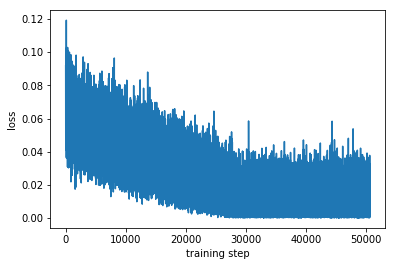

In [48]:
def weight_variable(shape,train=True):
    initial = tf.truncated_normal(shape, stddev=0.1)
    return tf.Variable(initial,trainable=train)
def bias_variable(shape,train=True):
    initial = tf.truncated_normal(shape, stddev=0.1)
    return tf.Variable(initial,trainable=train)

state_dim_ = env.observation_space.n
action_num_ = env.action_space.n

class DRQN():
    def __init__(self, sess, state_dim, action_dim=1, lamda=0.95, updateStep=3, output_num=4):
        self.state_dim = state_dim
        self.action_dim = action_dim
        self.state = tf.placeholder(tf.float32,[None,self.state_dim],name='state')
        self.next_state = tf.placeholder(tf.float32,[None,self.state_dim],name='next_state')
        self.lamda = lamda
        self.updateStep = updateStep
        self.action_output_num = output_num
        self.sess = sess
        self.reward_holder = tf.placeholder(tf.float32,[None], name='reward')
        self.action_index = tf.placeholder(shape=None,dtype=tf.int32)
        self.h_size = state_dim # only for convenience
        self.trace_length_holder = tf.placeholder(tf.int32)
        self.batch_size = tf.placeholder(dtype=tf.int32,shape=[])
        
    def buildQNetwork(self,):
        
        with tf.variable_scope('update-Qnetwork'):
            w1 = weight_variable([self.h_size,self.action_output_num])
            b1 = bias_variable([self.action_output_num])
            cell = tf.contrib.rnn.BasicLSTMCell(num_units=self.h_size,state_is_tuple=True)

        with tf.variable_scope('target-Qnetwork'):
            w1_ = weight_variable([self.h_size,self.action_output_num],train=False)
            b1_ = bias_variable([self.action_output_num],train=False)
            cell_ = tf.contrib.rnn.BasicLSTMCell(num_units=self.h_size,state_is_tuple=True)    
            
        self.e_params = tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES, scope='update-Qnetwork')
        self.t_params = tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES, scope='target-Qnetwork')
        
        self.state_input = tf.reshape(self.state,[-1,self.trace_length_holder,self.h_size])
        self.init_hidden_state = cell.zero_state(self.batch_size , tf.float32) 
        self.rnn,self.rnn_state = tf.nn.dynamic_rnn(\
                inputs=self.state_input,cell=cell,dtype=tf.float32,initial_state=self.init_hidden_state,scope='update-Qnetwork_rnn')
        self.rnn = tf.reshape(self.rnn,shape=[-1,self.h_size])
        self.Qs = (tf.matmul(self.rnn,w1)+b1)

        self.next_state_input = tf.reshape(self.next_state,[-1,self.trace_length_holder,self.h_size])
        self.init_hidden_state_ = cell_.zero_state(self.batch_size , tf.float32) # bacth size = tf.shape(self.next_state)[0]
        self.rnn_,self.rnn_state_ = tf.nn.dynamic_rnn(\
                inputs=self.next_state_input,cell=cell,dtype=tf.float32,initial_state=self.init_hidden_state_,scope='update-Qnetwork_rnn')
        self.rnn_ = tf.reshape(self.rnn_,shape=[-1,self.h_size])
        self.nextQs = (tf.matmul(self.rnn_,w1_)+b1_)
        
        increasing = tf.range(start=0, limit=tf.shape(self.action_index)[0] , delta=1)
        mask = tf.stack([increasing, self.action_index], axis=1)
        self.Q = tf.gather_nd(self.Qs, mask)
        
        self.nextQ = tf.reduce_max(self.nextQs,axis=1)
        self.targetQ = self.reward_holder+self.lamda*self.nextQ
        
        self.td_error = tf.square(self.targetQ - self.Q)
        
        #In order to only propogate accurate gradients through the network, we will mask the first
        #half of the losses for each trace as per Lample & Chatlot 2016
        self.maskA = tf.zeros([self.batch_size,self.trace_length_holder//2])
        self.maskB = tf.ones([self.batch_size,self.trace_length_holder//2])
        self.mask = tf.concat([self.maskA,self.maskB],1)
        self.mask = tf.reshape(self.mask,[-1])
        self.loss = tf.reduce_mean(self.td_error * self.mask)
                
        self.a = tf.argmax(self.Qs,1)
        
        self.trainOp = tf.train.AdamOptimizer(learning_rate=0.0005).minimize(self.loss,var_list=self.e_params)
    
    def learn(self,step,memory,init_state,trace_length=4,batch_size=32):
        
        _, loss = self.sess.run([self.trainOp,self.loss], feed_dict={self.state : list(memory[:,0]), 
                                                                     self.next_state: list(memory[:,3]),
                                                                     self.action_index:memory[:,1],
                                                                     self.reward_holder:memory[:,2],
                                                                     self.trace_length_holder:trace_length,
                                                                    self.init_hidden_state:init_state,
                                                                    self.init_hidden_state_:init_state,
                                                                    self.batch_size :batch_size})
        
        if step%self.updateStep==0:
            self.sess.run([tf.assign(tar,  eva) for tar, eva in zip(self.t_params, self.e_params)])
        return loss
    
    def choose_action(self,state,init_state,epsilon=0.9,batch_size=1):
        if np.random.uniform() < epsilon:
            return [np.random.randint(0, 4)], self.sess.run( self.rnn_state ,feed_dict={self.state:state,self.trace_length_holder:1,self.init_hidden_state:init_state,
                                                                    self.init_hidden_state_:init_state,self.batch_size :batch_size})
        else:
            return self.sess.run( self.a , feed_dict={self.state:state,self.trace_length_holder:1,self.init_hidden_state:init_state,
                                                                    self.init_hidden_state_:init_state,self.batch_size :batch_size}),self.sess.run( self.rnn_state , feed_dict={self.state:state,self.trace_length_holder:1,self.init_hidden_state:init_state,
                                                                    self.init_hidden_state_:init_state,self.batch_size :batch_size})

    
class replay_memory_episodewise():
    def __init__(self, memory_capacity = 1000, episode_num=99, one_piece_experiecnce_len=5,trace_length=4):
        self.buffer = []
        self.memory_capacity = memory_capacity
        self.one_piece_experiecnce_len = one_piece_experiecnce_len
        self.episode_num = episode_num
        self.trace_length =trace_length
        
    def add(self,experience):
        if len(self.buffer) + 1 >= self.memory_capacity:
            self.buffer[0:(1+len(self.buffer))-self.memory_capacity] = []
        self.buffer.append(experience)
            
    def replay(self,batch_size):
        sampled_episodes = random.sample(self.buffer,batch_size)
        sampledTraces = []
        for episode in sampled_episodes:
            point = np.random.randint(0,len(episode)+1-self.trace_length)
            sampledTraces.append(episode[point:point+self.trace_length])
        sampledTraces = np.array(sampledTraces)
        return np.reshape(sampledTraces,[batch_size*self.trace_length,self.one_piece_experiecnce_len])       
    
batch_size_ = 32    
tf.reset_default_graph()
sess_ = tf.Session()
h_size = state_dim_
model = DRQN(state_dim=state_dim_, lamda=0.95, updateStep=120, sess=sess_)
model.buildQNetwork()
init_op = tf.group(tf.global_variables_initializer(), tf.local_variables_initializer())
sess_.run(init_op)

M = replay_memory_episodewise(memory_capacity=500)
num_episodes = 1500

records = 0
loss_set=[]
e=1.
rewardset=[]
i=0
while i < num_episodes:
    s = env.reset()
    j = 0
    max_steps_in_episode = 99
    
    if i>500:
        e=0.001
        
    reward=0
    episodeBuffer = []
    step=0
    hidden_state = (np.zeros([1,h_size]),np.zeros([1,h_size]))
    
    while j<max_steps_in_episode:
        state_vector = np.zeros([1,state_dim_])
        state_vector[0,s]=1
        a,last_hidden_state = model.choose_action(state=state_vector,epsilon=e,init_state=hidden_state)
        s_next, r, d,_ = env.step(a[0])
        if r==0 and d==True:
            episodeBuffer.append(np.reshape(np.array([state_vector[0],a[0],-1,nextSate_vector[0],d]),[1,5]))
        else:
            episodeBuffer.append(np.reshape(np.array([state_vector[0],a[0],r,nextSate_vector[0],d]),[1,5]))
        nextSate_vector = np.zeros([1,state_dim_])    
        nextSate_vector[0,s_next]=1
        
        
        step+=1
        
        j+=1
        
        s = s_next
        hidden_state=last_hidden_state
        
        if records>M.memory_capacity:
            hidden_state_train = (np.zeros([batch_size_,h_size]),np.zeros([batch_size_,h_size])) 
            memory_batch = M.replay(batch_size_)
            loss_ = model.learn(records,memory=memory_batch,trace_length=M.trace_length,init_state=hidden_state_train)
            loss_set.append(loss_)
        if d==True:
            break
            
    
    if step>=M.trace_length:
        bufferArray = np.array(episodeBuffer)
        episodeBuffer = list(zip(bufferArray))
        M.add(episodeBuffer)
        records+=1
        i+=1
        if records>M.memory_capacity and i%20==0:
            print('episode: %d loss: %g'%(i, loss_))
            
    if r==1:
        rewardset.append(1) 
    else:
        rewardset.append(0)
        
plt.plot(loss_set)
plt.xlabel('training step')
plt.ylabel('loss')
plt.show()

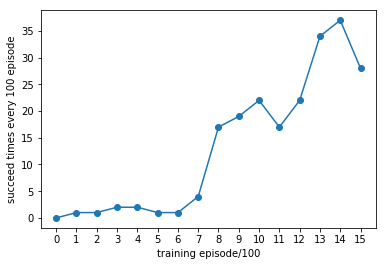

In [52]:
pass_sum=[]
i=1
a=0
while i<=len(rewardset):
    a+=rewardset[i-1]
    if i%100==0:
        pass_sum.append(a)
        a=0
    i+=1
plt.xticks(np.arange(0,len(pass_sum), 1.0))
plt.yticks(np.arange(0,max(pass_sum)+1, 5.0))
plt.plot( pass_sum,'-o')
plt.xlabel('training episode/100')
plt.ylabel('succeed times every 100 episode')
plt.show()

### 参考资料

[1][Simple Reinforcement Learning with Tensorflow Part 6: Partial Observability and Deep Recurrent Q-Networks](https://medium.com/emergent-future/simple-reinforcement-learning-with-tensorflow-part-6-partial-observability-and-deep-recurrent-q-68463e9aeefc)

[2][Deep Recurrent Q-Learning for Partially Observable MDPs](https://arxiv.org/pdf/1507.06527.pdf)

[3][Playing FPS Games with Deep Reinforcement Learning](https://arxiv.org/pdf/1609.05521.pdf)

# 8 Asynchronous Advantage Actor-Critic  (A3C)

A3C

<center>
    <img style="border-radius: 0.5em;
    box-shadow: 0 2px 4px 0 rgba(34,36,38,.12),0 2px 10px 0 rgba(34,36,38,.08);" 
    src="https://miro.medium.com/max/1050/1*YtnGhtSAMnnHSL8PvS7t_w.png" height="360" width="360">
    <br>
    <div style="color:orange; border-bottom: 1px solid #d9d9d9;
    display: inline-block;
    color: #999;
    padding: 2px;">A3C框架</div>
</center>

### 参考资料

[1][Simple Reinforcement Learning with Tensorflow Part 8: Asynchronous Actor-Critic Agents (A3C)](https://medium.com/emergent-future/simple-reinforcement-learning-with-tensorflow-part-8-asynchronous-actor-critic-agents-a3c-c88f72a5e9f2)

[2][Asynchronous Methods for Deep Reinforcement Learning](https://arxiv.org/pdf/1602.01783.pdf?source=post_page)

# 9 Soft Actor-Critic

在[1]提出的SAC框架，以**Actor-crtitic架构**为基础，最大的特点是分析策略价值时，不仅仅立足于环境反馈的奖赏，还包括一个评价策略随机程度的指标，其目的就是为了让策略足够好的同时，策略的随机性也足够强，[1]指出这种随机性使得策略在训练时可以捕捉到不同模式的局部最优，更有利于掌握尽可能多的好策略。引入熵的概念来评价策略的随机性，通过**应用Entropy-maximization**提高策略的搜索空间，避免局部最优，得到以下策略评价函数：



<center>
    <img style="border-radius: 0.3125em;
    box-shadow: 0 2px 4px 0 rgba(34,36,38,.12),0 2px 10px 0 rgba(34,36,38,.08);" 
    src="https://miro.medium.com/max/963/1*Iv6n2bXtN0FhkUh2ErF1gg.png" height="300" width="300">
    <br>
    <div style="color:orange; border-bottom: 1px solid #d9d9d9;
    display: inline-block;
    color: #999;
    padding: 2px;">基于熵评判策略随机性的策略评价函数</div>
</center>

将上述评价函数进行拆解并设计更新机制，可得：

**Soft Q-function**: $Q^{t}(s_t,a_t)=r(s_t,a_t)+\lambda E_{s_{t+1}}[V(s_{t+1})]$

其中，$V(s_t)=E_{a_t \sim \pi}[Q(s_t,a_t)-log \pi (a_t|s_t)]$，可以看到，策略的熵被包括在Soft-Q function的目标中：$H(\pi ( . |s_t))=E_{a_t \sim \pi}[-log \pi (a_t|s_t)]=-\sum_{a_t}-\pi (a_t|s_t)log \pi (a_t|s_t)$

相比于actor-critic算法，SAC对critic的应用中另辟蹊径：

**Policy update:** $\pi_{new}=arg \mathop {\min }\limits_{\pi^{'} \in II} D_{KL}(\pi^{'}(|s_t) || \frac{Q^{\pi_{old}(s_t,)}}{Z(s_t)})$

在策略更新中，SAC首先将策略限制为$\pi^{'} \in II$，一定程度减少策略空间的冗余，然后充分利用critic的作用，让策略选取动作的分布尽可能接近Q-function在各个动作的取值分布，使得策略尽可能反映critic的学习效果。

基于以上两个设计，引入基于神经网络的函数估计器：$\pi_{\phi}(a_t|s_t)$,$V_{\psi}(s_t)$以及$Q_{\theta}(s_t,a_t)$，同样采用随机梯度的形式，它们对应的学习目标和更新梯度如下：


<center>
    <img style="border-radius: 0.3125em;
    box-shadow: 0 2px 4px 0 rgba(34,36,38,.12),0 2px 10px 0 rgba(34,36,38,.08);" 
    src="https://miro.medium.com/max/1050/1*uB5XEhZU_yzAoC8fYRFTEg.png" height="450" width="450">
    <br>
    <div style="color:orange; border-bottom: 1px solid #d9d9d9;
    display: inline-block;
    color: #999;
    padding: 2px;">状态函数估计器目标函数</div>
</center>

<center>
    <img style="border-radius: 0.3125em;
    box-shadow: 0 2px 4px 0 rgba(34,36,38,.12),0 2px 10px 0 rgba(34,36,38,.08);" 
    src="https://miro.medium.com/max/1050/1*s_Bt-9Nc0HitK2oc69kjQQ.png" height="450" width="450">
    <br>
    <div style="color:orange; border-bottom: 1px solid #d9d9d9;
    display: inline-block;
    color: #999;
    padding: 2px;">状态函数估计器目标函数更新梯度</div>
</center>

<center>
    <img style="border-radius: 0.3125em;
    box-shadow: 0 2px 4px 0 rgba(34,36,38,.12),0 2px 10px 0 rgba(34,36,38,.08);" 
    src="https://miro.medium.com/max/950/1*zrj3NT3JGNjL4Ajk1nQLtQ.png" height="450" width="450">
    <br>
    <div style="color:orange; border-bottom: 1px solid #d9d9d9;
    display: inline-block;
    color: #999;
    padding: 2px;">Q值函数估计器目标函数</div>
</center>

<center>
    <img style="border-radius: 0.3125em;
    box-shadow: 0 2px 4px 0 rgba(34,36,38,.12),0 2px 10px 0 rgba(34,36,38,.08);" 
    src="https://miro.medium.com/max/1050/1*87ZgutwpQK263at79HMOvw.png" height="450" width="450">
    <br>
    <div style="color:orange; border-bottom: 1px solid #d9d9d9;
    display: inline-block;
    color: #999;
    padding: 2px;">Q值函数估计器目标函数更新梯度</div>
</center>

<center>
    <img style="border-radius: 0.3125em;
    box-shadow: 0 2px 4px 0 rgba(34,36,38,.12),0 2px 10px 0 rgba(34,36,38,.08);" 
    src="https://miro.medium.com/max/1050/1*NzbnUnz2YXypA2kNL4cCNg.png" height="450" width="450">
    <br>
    <div style="color:orange; border-bottom: 1px solid #d9d9d9;
    display: inline-block;
    color: #999;
    padding: 2px;">策略函数估计器目标函数</div>
</center>

因为$\pi$代表概率分布，令$a_t=f_{\phi}(\epsilon_t;s_t)$显式表示动作取值，取log并去掉与策略参数$\phi$的无关项后，策略目标函数改写为：

<center>
    <img style="border-radius: 0.3125em;
    box-shadow: 0 2px 4px 0 rgba(34,36,38,.12),0 2px 10px 0 rgba(34,36,38,.08);" 
    src="https://miro.medium.com/max/911/1*Blyj2yfrONthBI7LU487XA.png" height="450" width="450">
    <br>
    <div style="color:orange; border-bottom: 1px solid #d9d9d9;
    display: inline-block;
    color: #999;
    padding: 2px;">策略函数估计器目标函数重写</div>
</center>

<center>
    <img style="border-radius: 0.3125em;
    box-shadow: 0 2px 4px 0 rgba(34,36,38,.12),0 2px 10px 0 rgba(34,36,38,.08);" 
    src="https://miro.medium.com/max/885/1*R9KSoYWjFQo3UstXIvtcbA.png" height="450" width="450">
    <br>
    <div style="color:orange; border-bottom: 1px solid #d9d9d9;
    display: inline-block;
    color: #999;
    padding: 2px;">策略函数估计器目标函数更新梯度</div>
</center>

### SAC in Tensorflow

In [23]:
import tensorflow as tf
import tensorflow.contrib.slim as slim
import numpy as np
import gym
import matplotlib.pyplot as plt
%matplotlib inline

np.random.seed(2)
tf.set_random_seed(2)  # reproducible
env = gym.make('Pendulum-v0')
env.seed(1)  # reproducible
action_bound = env.action_space.high

In [24]:
class replay_memory():
    def __init__(self, memory_capacity, state_dim, action_dim=1):
        self.memory_capacity = memory_capacity
        self.memory = np.zeros((self.memory_capacity, 2*state_dim+1+1))  
        self.pointer = 0
        
    def store_experience(self, state,action,next_sate,reward):
        index = self.pointer%self.memory_capacity
        experience  = np.hstack((state,action,next_sate,reward))
        self.memory[index,:]=experience
        self.pointer+=1
        
    def replay(self,batch_size):
        memory_batch = []
        for i in range(batch_size):
            index = np.random.randint(0,self.memory_capacity)
            memory_batch.append(self.memory[index,:])
        return memory_batch

In [147]:
def weight_variable(shape,train=True):
    initial = tf.truncated_normal(shape, stddev=0.1)
    return tf.Variable(initial,trainable=train)
def bias_variable(shape,train=True):
    initial = tf.truncated_normal(shape, stddev=0.1)
    return tf.Variable(initial,trainable=train)

class agent():
    def __init__(self,sess,action_bound, action_dim=1, state_dim=3,lambda_=0.9,updateStep=20 ):
        self.state_dim = state_dim
        self.action_dim = action_dim
        self.state_holder = tf.placeholder(tf.float32,[None,state_dim], name='state')
        self.next_state_holder = tf.placeholder(tf.float32,[None,state_dim], name='next_state')
        self.reward_holder = tf.placeholder(tf.float32,[None,1], name='reward')
        self.action_holder = tf.placeholder(tf.float32,[None,self.action_dim], name='action')
        self.action_bound = action_bound
        self.var_holder = tf.placeholder(tf.float32,[None,self.action_dim],name='noise')
        self.lambda_ = lambda_
        self.updateStep = updateStep
        self.sess = sess
        
    def buildQnetwork(self,):
        with tf.variable_scope('Qnetwork1'):
            w11 = weight_variable([self.state_dim+self.action_dim, 10])
            b11 = bias_variable([10])
            w12 = weight_variable([10, 1])
            b12 = bias_variable([1])
        
        with tf.variable_scope('Qnetwork2'):
            w21 = weight_variable([self.state_dim+self.action_dim, 10])
            b21 = bias_variable([10])
            w22 = weight_variable([10, 1])
            b22 = bias_variable([1])
        

        self.q1_params = tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES, scope='Qnetwork1')
        self.q2_params = tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES, scope='Qnetwork2')   
        
        self.a = tf.stop_gradient(self.action_mean) 
        
        self.input = tf.concat([self.state_holder, self.action_mean],axis=1)
        hq1 = tf.nn.elu(tf.matmul(self.input, w11)+b11)
        self.q1 = tf.identity(tf.matmul(hq1,w12)+b12)
        
        hq2 = tf.nn.elu(tf.matmul(self.input, w21)+b21)
        self.q2 = tf.identity(tf.matmul(hq2,w22)+b22)
        
        self.q_select = tf.reduce_min(tf.concat([self.q1,self.q2], axis=1),axis=1)
       
        
    def buildVnetwork(self,):
        with tf.variable_scope('update-Vnetwork'):
            w1 = weight_variable([self.state_dim, 10])
            b1 = bias_variable([10])
            w2 = weight_variable([10, 1])
            b2 = bias_variable([1])
        with tf.variable_scope('target-Vnetwork'):
            w1_ = weight_variable([self.state_dim, 10],train=False)
            b1_ = bias_variable([10],train=False) 
            w2_ = weight_variable([10, 1],train=False)
            b2_ = bias_variable([1],train=False)
        self.v_e_params = tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES, scope='update-Vnetwork')
        self.v_t_params = tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES, scope='target-Vnetwork')
        
        hv1 = tf.nn.elu(tf.matmul(self.state_holder, w1)+b1)
        self.v = tf.identity(tf.matmul(hv1, w2)+b2)
        
        hv1_ = tf.nn.elu(tf.matmul(self.next_state_holder, w1_)+b1_)
        self.vnext = tf.identity(tf.matmul(hv1_, w2_)+b2_)
        
        
    def buildPolicynetwork(self,):
        with tf.variable_scope('Pnetwork'):
            w1 = weight_variable([self.state_dim, 10])
            b1 = bias_variable([10])
            w2 = weight_variable([10,1])
            b2 = bias_variable([1])
            
        self.p_params = tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES, scope='Pnetwork')
        h1 = tf.nn.elu(tf.matmul(self.state_holder,w1)+b1)
        
        self.action_mean = tf.multiply(tf.nn.tanh(tf.matmul(h1,w2)+b2),action_bound)
        
        self.action_prob = tf.distributions.Normal(loc=tf.reshape(self.action_mean,[-1,self.action_dim]), scale=tf.reshape(self.var_holder,[-1,self.action_dim])).prob(self.action_holder)
        
            
    def set_trainOp(self,):
        # Q function trainOp
        self.Qtarget = self.reward_holder + self.lambda_*self.vnext
        self.q_loss1 = tf.reduce_mean(tf.squared_difference(self.q1, self.Qtarget))
        self.q_loss2 = tf.reduce_mean(tf.squared_difference(self.q2, self.Qtarget))
        self.QtrainOp1 = tf.train.AdamOptimizer(learning_rate=0.002).minimize(self.q_loss1,var_list=self.q1_params)
        self.QtrainOp2 = tf.train.AdamOptimizer(learning_rate=0.002).minimize(self.q_loss2,var_list=self.q2_params)
        
        # V value trainOp
        self.vtarget = self.q_select+tf.log(self.action_prob)
        self.vloss = tf.reduce_mean(tf.squared_difference(self.v, self.vtarget))
        self.VtrainOp = tf.train.AdamOptimizer(learning_rate=0.002).minimize(self.vloss,var_list=self.v_e_params)
        
        # policy trainOp
        
        self.q_grads_a = tf.gradients(self.q_select,self.action_mean)[0]
  
        self.policy_grads_a = tf.gradients(self.action_prob,self.action_mean)[0]

        
        self.policy_grads1 = tf.gradients(ys=self.action_mean, xs=self.p_params,grad_ys=self.policy_grads_a-self.q_grads_a)
        self.policy_grads2 = tf.gradients(ys=tf.log(self.action_prob), xs=self.p_params)
        
        self.policy_grads = self.policy_grads1 + self.policy_grads2
        opt = tf.train.AdamOptimizer(learning_rate=0.001) 
        self.PtrainOp = opt.apply_gradients(zip(self.policy_grads, self.p_params))
        self.ploss = tf.reduce_mean(tf.squared_difference(tf.log(self.action_prob),self.q_select))
#         self.PtrainOp = tf.train.AdamOptimizer(learning_rate=0.001).minimize(self.ploss,var_list=self.p_params)
        
        
        
    def learn(self,step,memory,var):
        
        _,_,_,_, prob,loss = self.sess.run([self.QtrainOp1,self.QtrainOp2,self.VtrainOp,self.PtrainOp,self.action_prob,self.ploss], 
                                     feed_dict={self.state_holder : memory[:,0:self.state_dim],
                                                self.action_holder : memory[:,self.state_dim].reshape(-1,1), 
                                                self.next_state_holder : memory[:,-self.state_dim-1:-1],
                                                self.reward_holder:memory[:,-1].reshape(-1,1),
                                                self.var_holder:var})
#         print(prob)
#         print(memory[:,self.state_dim].reshape(-1,1))
        if step%self.updateStep==0:
            self.sess.run([tf.assign(tar,  eva) for tar, eva in zip(self.v_t_params, self.v_e_params)])
        
        return loss
    
        

In [148]:
M = replay_memory(memory_capacity=10000, state_dim=3, action_dim=1)
batch_size_ = 32
num_episodes = 200

tf.reset_default_graph()
sess_ = tf.Session()
model = agent(sess=sess_,action_bound=action_bound )

model.buildPolicynetwork()
model.buildQnetwork()
model.buildVnetwork()

model.set_trainOp()

init_op = tf.group(tf.global_variables_initializer(), tf.local_variables_initializer())
sess_.run(init_op)
records = 0
reward_set=[]
q_loss_set=[]
flag=0
max_steps_in_episode = 300
asets=[]
var=2.
for i in range(num_episodes):
    rewards=0
    s = env.reset()
    j = 0
    aset=[]
    while j<max_steps_in_episode:
        a_output = sess_.run(model.action_mean, feed_dict={model.state_holder:[s]})
       
        if i < 100:
            a = np.clip(np.random.normal(a_output[0],var),-2,2)
        else:
            a = np.clip(a_output[0],-2,2)
        aset.append(a)
    
        s_next, r, d, _ = env.step(a)
          
        j+=1
        records+=1
        rewards+=r

        if records>M.memory_capacity:
            var_ = 2.*np.ones((1,batch_size_)).reshape(-1,1)
            memory_batch = M.replay(batch_size=batch_size_)
            loss_ = model.learn(records,memory=np.array(memory_batch),var=var_ )

            if flag==0:
                flag=1
                print('train...')

        
        M.store_experience(state=s, action=a, reward=[r/10.], next_sate=s_next)

        if d==True:
            break
            
        s = s_next
    asets.append(aset)   
    print('num_episodes:%d r:%d'%(i,rewards))
    
    reward_set.append(rewards)

num_episodes:0 r:-1350
num_episodes:1 r:-1280
num_episodes:2 r:-1069
num_episodes:3 r:-1722
num_episodes:4 r:-1049
num_episodes:5 r:-1831
num_episodes:6 r:-1367
num_episodes:7 r:-1420
num_episodes:8 r:-1452
num_episodes:9 r:-1647
num_episodes:10 r:-1304
num_episodes:11 r:-1149
num_episodes:12 r:-1298
num_episodes:13 r:-1525
num_episodes:14 r:-1186
num_episodes:15 r:-1010
num_episodes:16 r:-1422
num_episodes:17 r:-1437
num_episodes:18 r:-1482
num_episodes:19 r:-983
num_episodes:20 r:-1633
num_episodes:21 r:-1241
num_episodes:22 r:-1589
num_episodes:23 r:-1440
num_episodes:24 r:-1062
num_episodes:25 r:-1307
num_episodes:26 r:-1179
num_episodes:27 r:-1168
num_episodes:28 r:-1710
num_episodes:29 r:-1802
num_episodes:30 r:-1421
num_episodes:31 r:-1162
num_episodes:32 r:-1663
num_episodes:33 r:-1075
num_episodes:34 r:-1468
num_episodes:35 r:-1189
num_episodes:36 r:-1593
num_episodes:37 r:-1233
num_episodes:38 r:-1070
num_episodes:39 r:-1405
num_episodes:40 r:-1241
num_episodes:41 r:-1543
num

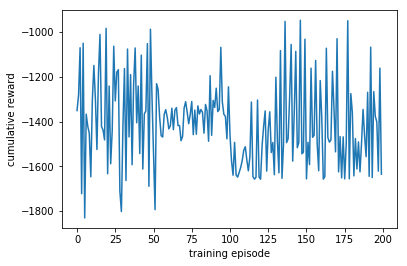

In [149]:

plt.xlabel('training episode')
plt.ylabel('cumulative reward')
plt.plot(reward_set)
plt.show()

In [ ]:
sess=tf.Session()
mu = np.array([1.,1.],np.float32).reshape(2,1)
a=tf.distributions.Normal(loc=mu, scale=[[1.],[1.]]).prob([[1.],[2.]])
print('multiple one-dimension gaussian calculation for multiple sample:')
print(sess.run(a))

a=tf.distributions.Normal(loc=[1.], scale=[1.]).prob([1.,2.])
print('one one-dimension gaussian calculation for multiple sample:')
print(sess.run(a))

a=tf.distributions.Normal(loc=[1.,2.], scale=[[[1.,2.],[1.,2.]]]).prob([[1.,2.]])
print('one two-dimension gaussian calculation for one sample:')
print(sess.run(a))

a=tf.distributions.Normal(loc=[[1.,2.],[1.,2.]], scale=[[[1.,2.],[1.,2.]],[[1.,2.],[1.,2.]]]).prob([[1.,2.],[1.,2.]])
print('multiple two-dimension gaussian calculation for multiple sample:')
print(sess.run(a))

### 参考资料

[1][Soft Actor-Critic: Off-Policy Maximum Entropy Deep Reinforcement Learning with a Stochastic Actor](https://arxiv.org/abs/1801.01290)

[2][Soft Actor-Critic Demystified-An intuitive explanation of the theory and a PyTorch implementation guide](https://towardsdatascience.com/soft-actor-critic-demystified-b8427df61665)

# 10 Evolutionary algorithm for RL

In [ ]:
# 最简单的诠释: 找到 solution 中的值
import numpy as np
solution = np.array([0.5, 0.1, -0.3])
def f(w): return -np.sum((w - solution)**2)

npop = 50      # 种群数
sigma = 0.1    # 噪点标准差
alpha = 0.001  # 学习率
w = np.random.randn(3) # 对 solution 的初始猜测
for i in range(300):
  N = np.random.randn(npop, 3)  # 产生噪点
  R = np.zeros(npop)
  for j in range(npop):
    w_try = w + sigma*N[j]
    R[j] = f(w_try)             # 得到环境奖励
  A = (R - np.mean(R)) / np.std(R)  # 归一化奖励
  w = w + alpha/(npop*sigma) * np.dot(N.T, A)   # 更新参数

### 参考资料

[1][Evolution Strategies as a Scalable Alternative to Reinforcement Learning](https://openai.com/blog/evolution-strategies/)

[2][莫烦tutorial之Evolution Strategy 强化学习](https://morvanzhou.github.io/tutorials/machine-learning/evolutionary-algorithm/4-04-evolution-strategy-reinforcement-learning/)

# 11 Multi-agent